In [103]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp
from sklearn import datasets
from numpy import linalg as LA
from sklearn.metrics.pairwise import pairwise_distances
import sys
from scipy.stats import entropy
from sklearn.datasets import load_digits
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from scipy.cluster.hierarchy import dendrogram, linkage
from multiprocessing import Pool
import itertools
from scipy.cluster.hierarchy import fcluster
from collections import Counter
import datetime

In [2]:
#Our Dataset
data = np.array([0.40,0.53,0.22,0.38,0.35,0.32,0.26,0.19,0.08,0.41,0.45,0.30]).reshape(6,2)
print(data)

[[0.4  0.53]
 [0.22 0.38]
 [0.35 0.32]
 [0.26 0.19]
 [0.08 0.41]
 [0.45 0.3 ]]


In [3]:
digits = load_digits()
targets = digits.target
digits.data.shape

(1797, 64)

Visualising Data

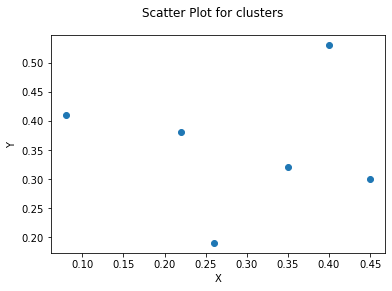

In [4]:
fig = plt.figure()
fig.suptitle('Scatter Plot for clusters')
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.scatter(data[:,0],data[:,1])

  Distance Matrix: It is the matrix which contains distances between all the datapoints. If you have n datapoints, the distance matrix will be of order nXn.
  To calculate distance matrix, we use pairwise distance function of sklearn which returns distance matrix. For hierarchical clustering we use euclidean distance to calculate distance between two datapoints.

In [5]:
def hierarchical_clustering(data,linkage,no_of_clusters, targets, alpha = 0, verbose = False):  
    #first step is to calculate the initial distance matrix
    #it consists distances from all the point to all the point
    color = ['r','g','b','y','c','m','k','w']
    initial_distances = pairwise_distances(data,metric='euclidean')
    #making all the diagonal elements infinity 
    np.fill_diagonal(initial_distances,sys.maxsize)
    clusters = find_clusters(initial_distances,linkage, targets, alpha, verbose) 
    
    #plotting the clusters
    iteration_number = initial_distances.shape[0] - no_of_clusters
    clusters_to_plot = clusters[iteration_number]
    arr = np.unique(clusters_to_plot)
    
    indices_to_plot = []
    fig = plt.figure()
    fig.suptitle('Scatter Plot for clusters')
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    for x in np.nditer(arr):
        indices_to_plot.append(np.where(clusters_to_plot==x))
    p=0
    
    print(clusters_to_plot)
    for i in range(0,len(indices_to_plot)):
        for j in np.nditer(indices_to_plot[i]):
               ax.scatter(data[j,0],data[j,1], c= color[p])
        p = p + 1
        
    plt.show()
    

In [6]:
def add_dist(lst_clusters, clust_labels, target_labels):
    
    true_list = []
    false_list = []
    entropy_true_res = []
    entropy_false_res = []
    
    for it in lst_clusters:
        
        true_list = list(
            target_labels[clust_labels == it] == it
        ) + [True]
        
        false_list = list(
            target_labels[clust_labels == it] == it
        ) + [False]
        
        entropy_true_res.append(entropy(true_list))
        entropy_false = entropy(false_list)
        
        if str(entropy_false) == "nan":
            entropy_false_res.append(0)
        else:
            entropy_false_res.append(entropy_false)
    
    return entropy_true_res, entropy_false_res

In [7]:
def find_clusters(input,linkage, targets, alpha = 0, verbose = False):
    clusters = {}
    row_index = -1
    col_index = -1
    array = []
    

    for n in range(input.shape[0]):
        array.append(n)
        
    clusters[0] = array.copy()

    df_clusters = pd.DataFrame([])
    df_clusters["element"] = range(input.shape[0])

    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
    for k in tqdm(range(1, input.shape[0])):
        print("k = ", k)
        min_val = sys.maxsize
        
        df_clusters["cluster"] = array
        
#         for i in range(0, input.shape[0]):
#             for j in range(0, input.shape[1]):
#                 if i != j:

#                     df_cluster_i = df_clusters[df_clusters.cluster == array[i]]
#                     el_cluster_i = list(df_cluster_i.element)

#                     el_cluster_i.append(j)

#                     input[i][j] = input[i][j] + alpha * entropy(
#                         [targets[x] for x in el_cluster_i]
#                     )

#     #                 lst_clusters = array,unique()
#     #                 entropy_true_res, entropy_false_res = \
#     #                     add_dist(lst_clusters, array, target_labels)

#     #                 entropy_df = pd.DataFrame([], columns=range(n_clusters))

#     #                 for it in range(n_clusters):
#     #                     entropy_df[it] = ((target_labels == it)*entropy_true_res[it]\
#     #                     + (target_labels != it)*entropy_false_res[it])
                    
        for i in range(0, input.shape[0]):
            for j in range(0, input.shape[1]):
                if(input[i][j]<=min_val):
                    min_val = input[i][j]
                    row_index = i
                    col_index = j
                    
        #once we find the minimum value, we need to update the distance matrix
        #updating the matrix by calculating the new distances from the cluster to all points
        
        #for Single Linkage
        if(linkage == "single" or linkage =="Single"):
            for i in range(0,input.shape[0]):
                if(i != col_index):
                    #we calculate the distance of every data point from newly formed cluster and update the matrix.
                    temp = min(input[col_index][i],input[row_index][i])
                    #we update the matrix symmetrically as our distance matrix should always be symmetric
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        #for Complete Linkage
        elif(linkage=="Complete" or linkage == "complete"):
             for i in range(0,input.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = min(input[col_index][i],input[row_index][i])
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        #for Average Linkage
        elif(linkage=="Average" or linkage == "average"):
             for i in range(0,input.shape[0]):
                if(i != col_index and i!=row_index):
                    temp = (input[col_index][i]+input[row_index][i])/2
                    input[col_index][i] = temp
                    input[i][col_index] = temp
        
        elif(linkage=="Centroid" or linkage =="centroid"):
            for i in range(0,input.shape[0]):
                if(i!=col_index and i!=row_index):
                    dist_centroid = cal_dist_from_centroid(i,row_index,col_index)
                    input[col_index][i] = dist_centroid
                    input[i][col_index] = dist_centroid
                   
        #set the rows and columns for the cluster with higher index i.e. the row index to infinity
        #Set input[row_index][for_all_i] = infinity
        #set input[for_all_i][row_index] = infinity
        for i in range (0,input.shape[0]):
            input[row_index][i] = sys.maxsize
            input[i][row_index] = sys.maxsize
            
        #Manipulating the dictionary to keep track of cluster formation in each step
        #if k=0,then all datapoints are clusters
       
        minimum = min(row_index,col_index)
        maximum = max(row_index,col_index)
        for n in range(len(array)):
            if(array[n]==maximum):
                array[n] = minimum
        clusters[k] = array.copy()
        if verbose:
            print(k)
        
    return clusters

In [8]:
%%time
def find_clusters_with_entropy(alpha = 0):
    linkage = "single"
    # alpha = 0
    # len_data = len(digits.data)
    len_data = 500
    data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
    targets = digits.target[:len_data].copy()
    np.fill_diagonal(data,sys.maxsize)

    clusters = {}
    row_index = -1
    col_index = -1
    array = []


    for n in range(data.shape[0]):
        array.append(n)

    clusters[0] = array.copy()

    df_clusters = pd.DataFrame([])
    df_clusters["element"] = range(data.shape[0])
    num_targets = len(np.unique(targets))
    lst_targets = np.unique(targets)

    
    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
#     for k in tqdm(range(1, data.shape[0])):
    for k in tqdm(range(1, data.shape[0])):
        min_val = sys.maxsize

        df_clusters["cluster"] = array
        data_with_entropy = data.copy()
        for i in range(0, data.shape[0]):
            entropy_array = []
    #         if (i == 10):
    #             print("hi1")
            df_cluster_i = df_clusters[df_clusters.cluster == array[i]]
            el_cluster_i = list(df_cluster_i.element)

            len_el_cluster_i = len(el_cluster_i)
            len_el_cluster_i_next = len_el_cluster_i + 1

    #         if (i == 10):
    #             print("hi3")
    #         el_cluster_i_freq = np.array(np.zeros(num_targets))
    #         counts_elements = Counter(el_cluster_i)

    #         for key in counts_elements.keys():
    # #             print(key)
    #             el_cluster_i_freq[targets[key]] = counts_elements[targets[key]]

            for trg in lst_targets:
                el_cluster_i_tmp = targets[el_cluster_i].copy()
                el_cluster_i_tmp = np.append(el_cluster_i_tmp, trg)
                counts_elements = Counter(el_cluster_i_tmp)
                entropy_array.append(
                    entropy(np.fromiter(list(counts_elements.values()), dtype = float)/len_el_cluster_i_next)
                )

    #         if (i == 10):
    #             print("hi2")
            for j in range(0, data.shape[1]):
                if i != j:

    # #                 el_cluster_i_copy = el_cluster_i.copy()

    # #                 el_cluster_i_copy.append(j)

    # #                 unique_elements, counts_elements = np.unique(
    # #                     [targets[x] for x in el_cluster_i_copy]
    # #                     , return_counts=True
    # #                 )
    # #                 print(i, j)
    #                 el_cluster_i_freq_copy = el_cluster_i_freq.copy()
    #                 el_cluster_i_freq_copy[targets[j]] = el_cluster_i_freq_copy[targets[j]] + 1
    #                 el_cluster_i_freq_copy = el_cluster_i_freq_copy[el_cluster_i_freq_copy.nonzero()]

    #                 data[i][j] = data[i][j] + alpha * entropy(
    #                     el_cluster_i_freq_copy/(len_el_cluster_i + 1)
    #                 )
                    data_with_entropy[i][j] = data_with_entropy[i][j] + alpha * entropy_array[targets[j]]

    #                 print(alpha * entropy_array[targets[j]])


    #             if (data[i][j] <= min_val):
    #                 min_val = data[i][j]
    #                 row_index = i
    #                 col_index = j

        #                 lst_clusters = array,unique()
        #                 entropy_true_res, entropy_false_res = \
        #                     add_dist(lst_clusters, array, target_labels)

        #                 entropy_df = pd.DataFrame([], columns=range(n_clusters))

        #                 for it in range(n_clusters):
        #                     entropy_df[it] = ((target_labels == it)*entropy_true_res[it]\
        #                     + (target_labels != it)*entropy_false_res[it])

    #     for i in range(0, data.shape[0]):
    #         for j in range(0, data.shape[1]):
    #             if(data[i][j]<=min_val):
    #                 min_val = data[i][j]
    #                 row_index = i
    #                 col_index = j
        ind = np.unravel_index(np.argmin(data_with_entropy, axis=None), data.shape)
        row_index = ind[0]
        col_index = ind[1]
        min_val = data_with_entropy[ind]
    #     print(ind)

    #     #once we find the minimum value, we need to update the distance matrix
    #     #updating the matrix by calculating the new distances from the cluster to all points

    #     #for Single Linkage
    #     if(linkage == "single" or linkage =="Single"):
    #         for i in range(0,data.shape[0]):
    #             if(i != col_index):
    #                 #we calculate the distance of every data point from newly formed cluster and update the matrix.
    #                 temp = min(data[col_index][i],data[row_index][i])
    #                 #we update the matrix symmetrically as our distance matrix should always be symmetric
    #                 data[col_index][i] = temp
    #                 data[i][col_index] = temp
    #     #for Complete Linkage
    #     elif(linkage=="Complete" or linkage == "complete"):
    #          for i in range(0,data.shape[0]):
    #             if(i != col_index and i!=row_index):
    #                 temp = min(data[col_index][i],data[row_index][i])
    #                 data[col_index][i] = temp
    #                 data[i][col_index] = temp
    #     #for Average Linkage
    #     elif(linkage=="Average" or linkage == "average"):
    #          for i in range(0,data.shape[0]):
    #             if(i != col_index and i!=row_index):
    #                 temp = (data[col_index][i]+data[row_index][i])/2
    #                 data[col_index][i] = temp
    #                 data[i][col_index] = temp

    #     elif(linkage=="Centroid" or linkage =="centroid"):
    #         for i in range(0,data.shape[0]):
    #             if(i!=col_index and i!=row_index):
    #                 dist_centroid = cal_dist_from_centroid(i,row_index,col_index)
    #                 data[col_index][i] = dist_centroid
    #                 data[i][col_index] = dist_centroid

        part1 = df_clusters[df_clusters.cluster == array[row_index]].element
        part2 = df_clusters[df_clusters.cluster == array[col_index]].element
        for i1 in part1:
            for i2 in part2:
                data[i1][i2] = sys.maxsize
                data[i2][i1] = sys.maxsize

        for i1 in part1:
            array[i1] = k + data.shape[0]
        for i2 in part2:
            array[i2] = k + data.shape[0]
        #set the rows and columns for the cluster with higher index i.e. the row index to infinity
        #Set data[row_index][for_all_i] = infinity
        #set data[for_all_i][row_index] = infinity
    #     for i in range (0,data.shape[0]):
    #         data[row_index][i] = sys.maxsize
    #         data[i][row_index] = sys.maxsize

    #     #Manipulating the dictionary to keep track of cluster formation in each step
    #     #if k=0,then all datapoints are clusters

    #     minimum = min(row_index,col_index)
    #     maximum = max(row_index,col_index)
    #     for n in range(len(array)):
    #         if(array[n]==maximum):
    #             array[n] = minimum
        clusters[k] = array.copy()
    
    print("hihi2")
#     print(data.shape[0])
    acc_res = cluster_score(targets, clusters, data)
    
    print("hihi3")
    return acc_res

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.9 µs


In [9]:
%%time
def find_clusters_with_entropy(alpha = 0):
    linkage = "single"
    # alpha = 0
    # len_data = len(digits.data)
    len_data = 500
    data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
    targets = digits.target[:len_data].copy()
    np.fill_diagonal(data,sys.maxsize)

    clusters = {}
    row_index = -1
    col_index = -1
    array = []


    for n in range(data.shape[0]):
        array.append(n)

    clusters[0] = array.copy()

    df_clusters = pd.DataFrame([])
    df_clusters["element"] = range(data.shape[0])
    num_targets = len(np.unique(targets))
    lst_targets = np.unique(targets)

    
    
    
    cluster_counter_array = np.array(2 * len_data)
    target_counter_array = np.array(2 * len_data)
    cluster_array_entropy = np.array(2 * len_data)
    len_add_arr = 2

    cluster_counter_array = [
        Counter([targets[i]])
        for i in range(len_data)
    ]

    target_counter_array = np.matrix(
        [
            [
                Counter(targets[[i, j]])
                for j in range(len_data)
            ]
            for i in range(len_data)
        ]
    )

    cluster_array_entropy = np.matrix(
        [
            [
                entropy(
                    np.fromiter(
                        list(target_counter_array[i][j].values())
                        , dtype = float
                    )/len_add_arr
                )
                for j in range(len_data)
            ]
            for i in range(len_data)
        ]
    )
    
    
    
    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
#     for k in tqdm(range(1, data.shape[0])):
    for k in tqdm(range(1, data.shape[0])):
        min_val = sys.maxsize

        df_clusters["cluster"] = array
        data_with_entropy = data.copy()
        for i in range(0, data.shape[0]):
            for j in range(0, data.shape[1]):
                if i != j:
                    data_with_entropy[i][j] = data_with_entropy[i][j] + alpha * cluster_array_entropy[array[i]][array[j]]

        ind = np.unravel_index(np.argmin(data_with_entropy, axis=None), data.shape)
        row_index = ind[0]
        col_index = ind[1]
        min_val = data_with_entropy[ind]

        part1 = df_clusters[df_clusters.cluster == array[row_index]].element
        part2 = df_clusters[df_clusters.cluster == array[col_index]].element
        for i1 in part1:
            for i2 in part2:
                data[i1][i2] = sys.maxsize
                data[i2][i1] = sys.maxsize

        for i1 in part1:
            array[i1] = k + data.shape[0]
        for i2 in part2:
            array[i2] = k + data.shape[0]
            
        clusters[k] = array.copy()
    
        add_cluster_counter = cluster_counter_array[row_index] + cluster_counter_array(col_index)
        
        add_col_counter = [x + add_cluster_counter for x in cluster_counter_array]
        add_col_entropy = [entropy(x) for x in add_col_counter]
        
        cluster_counter_array = np.append(
            cluster_counter_array
            , add_cluster_counter
        )
        
        target_counter_array = np.hstack((target_counter_array, add_col_counter))
        add_col_counter = np.append(add_col_counter, add_cluster_counter)
        target_counter_array = np.append(target_counter_array, add_col_counter)
        
        cluster_array_entropy = np.hstack((cluster_array_entropy, add_col_entropy))
        add_col_entropy = np.append(add_col_counter, sys.maxsize)
        cluster_array_entropy = np.append(cluster_array_entropy, add_col_entropy)
        
    print("hihi2")
#     print(data.shape[0])
    acc_res = cluster_score(targets, clusters, data)
    
    print("hihi3")
    return acc_res

CPU times: user 30 µs, sys: 6 µs, total: 36 µs
Wall time: 44.6 µs


In [10]:
%%time
def find_clusters_with_entropy(alpha = 0, len_data = 500):
    linkage = "single"
    # alpha = 0
    # len_data = len(digits.data)
#     len_data = 1000
    data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
    targets = digits.target[:len_data].copy()
    np.fill_diagonal(data,sys.maxsize)

    clusters = {}
    row_index = -1
    col_index = -1
    array = []


    for n in range(data.shape[0]):
        array.append(n)

    clusters[0] = array.copy()

    df_clusters = pd.DataFrame([])
    df_clusters["element"] = range(data.shape[0])
    num_targets = len(np.unique(targets))
    lst_targets = np.unique(targets)




    cluster_counter_array = np.array(2 * len_data)
    target_counter_array = np.array(2 * len_data)
    cluster_array_entropy = np.array(2 * len_data)
    len_add_arr = 2

    cluster_counter_array = [
        Counter([targets[i]])
        for i in range(len_data)
    ]

    target_counter_array = \
        [
            [
                Counter(targets[[i, j]])
                for j in range(len_data)
            ]
            for i in range(len_data)
        ]


    cluster_array_entropy = \
        [
            [
                entropy(
                    np.fromiter(
                        list(target_counter_array[i][j].values())
                        , dtype = float
                    )/len_add_arr
                )
                for j in range(len_data)
            ]
            for i in range(len_data)
        ]




    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
    #     for k in tqdm(range(1, data.shape[0])):
    for k in tqdm(range(1, data.shape[0])):
#         print(k)
        min_val = sys.maxsize

        df_clusters["cluster"] = array
        data_with_entropy = data.copy()
        
        cluster_array_entropy_k = np.array(
            [
                [
                    cluster_array_entropy[array[i]][array[j]]
                    for j in range(0, data.shape[1])
                ]
                for i in range(0, data.shape[0])
            ]
        )
        
        data_with_entropy = data_with_entropy + alpha * cluster_array_entropy_k
#         for i in range(0, data.shape[0]):
#             for j in range(0, data.shape[1]):
#                 if i != j:
#                     data_with_entropy[i][j] = data_with_entropy[i][j] + alpha * cluster_array_entropy[array[i]][array[j]]

        ind = np.unravel_index(np.argmin(data_with_entropy, axis=None), data.shape)
        row_index = ind[0]
        col_index = ind[1]
        min_val = data_with_entropy[ind]

        part1 = df_clusters[df_clusters.cluster == array[row_index]].element
        part2 = df_clusters[df_clusters.cluster == array[col_index]].element
        for i1 in part1:
            for i2 in part2:
                data[i1][i2] = sys.maxsize
                data[i2][i1] = sys.maxsize

        for i1 in part1:
            array[i1] = k - 1 + data.shape[0]
        for i2 in part2:
            array[i2] = k - 1 + data.shape[0]

        clusters[k] = array.copy()

        add_cluster_counter = cluster_counter_array[row_index] + cluster_counter_array[col_index]

        add_col_counter = [[x + add_cluster_counter] for x in cluster_counter_array]
        add_col_entropy = [
            [
                entropy(
                    list(x[0].values())/np.sum(list(x[0].values()))
                )
            ]
            for x in add_col_counter
        ]

        cluster_counter_array = np.append(
            cluster_counter_array
            , add_cluster_counter
        )


    #     if k == 1:
    #         break
        target_counter_array = np.hstack((target_counter_array, add_col_counter))
        add_col_counter = add_col_counter + [[add_cluster_counter]]
        target_counter_array = np.concatenate(
            [target_counter_array, np.array(add_col_counter).reshape(1, -1)]
        )
    #     target_counter_array = target_counter_array + [add_col_counter]

        cluster_array_entropy = np.hstack((cluster_array_entropy, add_col_entropy))
        add_col_entropy = add_col_entropy + [[sys.maxsize]]
        cluster_array_entropy = np.concatenate(
            [cluster_array_entropy, np.array(add_col_entropy).reshape(1, -1)]
        )
    #     cluster_array_entropy = cluster_array_entropy + [add_col_entropy]
#     print("hihi2")
    #     print(data.shape[0])
    # acc_res = cluster_score(targets, clusters, data)
    return acc_res

CPU times: user 17 µs, sys: 3 µs, total: 20 µs
Wall time: 26.5 µs


In [11]:
%%time
def find_clusters_with_entropy(alpha = 0, len_data = 500):
    linkage = "single"
    # alpha = 0
    # len_data = len(digits.data)
#     len_data = 1000
    data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
    targets = digits.target[:len_data].copy()
    np.fill_diagonal(data,sys.maxsize)

    clusters = {}
    row_index = -1
    col_index = -1
    array = []


    for n in range(data.shape[0]):
        array.append(n)

    clusters[0] = array.copy()

    df_clusters = pd.DataFrame([])
    df_clusters["element"] = range(data.shape[0])
    num_targets = len(np.unique(targets))
    lst_targets = np.unique(targets)




    cluster_counter_array = np.array(2 * len_data)
    target_counter_array = np.array(2 * len_data)
    cluster_array_entropy = np.array(2 * len_data)
    len_add_arr = 2

    cluster_counter_array = [
        Counter([targets[i]])
        for i in range(len_data)
    ]

    target_counter_array = pd.DataFrame(
        [
            [
                Counter(targets[[i, j]])
                for j in range(len_data)
            ]
            for i in range(len_data)
        ]
    )


    cluster_array_entropy = pd.DataFrame(
        [
            [
                entropy(list(target_counter_array[i][j].values())/np.int64(len_add_arr))
                for j in range(len_data)
            ]
            for i in range(len_data)
        ]
    )



    #finding minimum value from the distance matrix
    #note that this loop will always return minimum value from bottom triangle of matrix
    #     for k in tqdm(range(1, data.shape[0])):
    for k in tqdm(range(1, data.shape[0])):
#         print(k)
        min_val = sys.maxsize

        df_clusters["cluster"] = array
        data_with_entropy = data.copy()
        
        cluster_array_entropy_k = np.array(
            [
                [
                    cluster_array_entropy[array[i]][array[j]]
                    for j in range(0, data.shape[1])
                ]
                for i in range(0, data.shape[0])
            ]
        )
        
        data_with_entropy = data_with_entropy + alpha * cluster_array_entropy_k
#         for i in range(0, data.shape[0]):
#             for j in range(0, data.shape[1]):
#                 if i != j:
#                     data_with_entropy[i][j] = data_with_entropy[i][j] + alpha * cluster_array_entropy[array[i]][array[j]]

        ind = np.unravel_index(np.argmin(data_with_entropy, axis=None), data.shape)
        row_index = ind[0]
        col_index = ind[1]
        min_val = data_with_entropy[ind]

        part1 = df_clusters[df_clusters.cluster == array[row_index]].element
        part2 = df_clusters[df_clusters.cluster == array[col_index]].element
        data[list(part1), list(part2)] = sys.maxsize
#         for i1 in part1:
#             for i2 in part2:
#                 data[i1][i2] = sys.maxsize
#                 data[i2][i1] = sys.maxsize

        new_cluster_num = k - 1 + data.shape[0]
        array[list(part1)] = new_cluster_num
#         for i1 in part1:
#             array[i1] = k - 1 + data.shape[0]

        array[list(part2)] = new_cluster_num
#         for i2 in part2:
#             array[i2] = k - 1 + data.shape[0]

        clusters[k] = array.copy()

        add_cluster_counter = cluster_counter_array[row_index] + cluster_counter_array[col_index]

        target_counter_array.drop([array[row_index], array[col_index]], axis = 0, inplace = True)
        target_counter_array.drop([array[row_index], array[col_index]], axis = 1, inplace = True)
        
        add_col_counter = [
            cluster_counter_array[i] + add_cluster_counter
            for i in target_counter_array.columns
        ]
        
        add_col_entropy = [
            entropy(
                list(x[0].values())/np.sum(list(x[0].values()))
            )
            for x in add_col_counter
        ]

        cluster_counter_array = np.append(
            cluster_counter_array
            , add_cluster_counter
        )

        target_counter_array[new_cluster_num] = add_col_counter
        add_col_counter = add_col_counter.append(add_cluster_counter)
        target_counter_array.append(
            pd.Series(add_col_counter, name = new_cluster_num)
            , inplace = True
        )
    #     if k == 1:
    #         break
        
#         target_counter_array = np.hstack((target_counter_array, add_col_counter))
#         add_col_counter = add_col_counter + [[add_cluster_counter]]
#         target_counter_array = np.concatenate(
#             [target_counter_array, np.array(add_col_counter).reshape(1, -1)]
#         )
    #     target_counter_array = target_counter_array + [add_col_counter]


        cluster_array_entropy[new_cluster_num] = add_col_entropy
        add_col_entropy = add_col_entropy.append(add_cluster_counter)
        cluster_array_entropy.append(
            pd.Series(add_col_entropy, name = new_cluster_num)
            , inplace = True
        )
        
#         cluster_array_entropy = np.hstack((cluster_array_entropy, add_col_entropy))
#         add_col_entropy = add_col_entropy + [[sys.maxsize]]
#         cluster_array_entropy = np.concatenate(
#             [cluster_array_entropy, np.array(add_col_entropy).reshape(1, -1)]
#         )
    #     cluster_array_entropy = cluster_array_entropy + [add_col_entropy]
#     print("hihi2")
    #     print(data.shape[0])
    # acc_res = cluster_score(targets, clusters, data)
    return acc_res

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 19.1 µs


# v1

In [111]:
%%time
# def find_clusters_with_entropy(alpha = 0, len_data = 500):
alpha = 0
len_data = 100
linkage = "single"
# alpha = 0
# len_data = len(digits.data)
#     len_data = 1000
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
targets = digits.target[:len_data].copy()
np.fill_diagonal(data,sys.maxsize)

clusters = {}
row_index = -1
col_index = -1
array = np.array([])


for n in range(data.shape[0]):
    array = np.append(array, n)

clusters[0] = array.copy()

df_clusters = pd.DataFrame([])
df_clusters["element"] = range(data.shape[0])
num_targets = len(np.unique(targets))
lst_targets = np.unique(targets)




cluster_counter_array = np.array(2 * len_data)
target_counter_array = np.array(2 * len_data)
cluster_array_entropy = np.array(2 * len_data)
len_add_arr = 2

cluster_counter_array = [
    Counter([targets[i]])
    for i in range(len_data)
]

target_counter_array = pd.DataFrame(
    [
        [
            Counter(targets[[i, j]])
            for j in range(len_data)
        ]
        for i in range(len_data)
    ]
)

cluster_array_entropy = pd.DataFrame(
    [
        [
            entropy(list(target_counter_array[i][j].values())/np.int64(len_add_arr))
            for j in range(len_data)
        ]
        for i in range(len_data)
    ]
)

#finding minimum value from the distance matrix
#note that this loop will always return minimum value from bottom triangle of matrix
#     for k in tqdm(range(1, data.shape[0])):
for k in tqdm(range(1, data.shape[0])):
#     print(k)
    ind_tmp = 0
    dt = datetime.datetime.now()
#     min_val = sys.maxsize

    df_clusters["cluster"] = array
    data_with_entropy = data.copy()

    cluster_array_entropy_k = np.array(
        [
            [
                cluster_array_entropy[array[i]][array[j]]
                for j in range(0, data.shape[1])
            ]
            for i in range(0, data.shape[0])
        ]
    )
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1

    data_with_entropy = data_with_entropy + alpha * cluster_array_entropy_k
#         for i in range(0, data.shape[0]):
#             for j in range(0, data.shape[1]):
#                 if i != j:
#                     data_with_entropy[i][j] = data_with_entropy[i][j] + alpha * cluster_array_entropy[array[i]][array[j]]

    ind = np.unravel_index(np.argmin(data_with_entropy, axis=None), data.shape)
    row_index = ind[0]
    col_index = ind[1]
    min_val = data_with_entropy[ind]
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1

#     print("MIN ", min_val, row_index, col_index)
    part1 = list(df_clusters[df_clusters.cluster == array[row_index]].element)
    part2 = list(df_clusters[df_clusters.cluster == array[col_index]].element)
#     all_parts = list(set(part1).union(set(part2)))
#     print(all_parts)
    all_parts_combinations = np.transpose([np.tile(part1, len(part2)), np.repeat(part2, len(part1))])
    data[all_parts_combinations[:, 0], all_parts_combinations[:, 1]] = sys.maxsize
    data[all_parts_combinations[:, 1], all_parts_combinations[:, 0]] = sys.maxsize
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1
    
#     print("MIN part ", part1, part2, all_parts)
#     print("MIN ", data[ind], row_index, col_index, all_parts)
#     data[list(part1), list(part2)] = sys.maxsize
#         for i1 in part1:
#             for i2 in part2:
#                 data[i1][i2] = sys.maxsize
#                 data[i2][i1] = sys.maxsize

    new_cluster_num = k - 1 + data.shape[0]

    add_cluster_counter = cluster_counter_array[row_index] + cluster_counter_array[col_index]

    target_counter_array.drop([array[row_index], array[col_index]], axis = 0, inplace = True)
    target_counter_array.drop([array[row_index], array[col_index]], axis = 1, inplace = True)
    
    cluster_array_entropy.drop([array[row_index], array[col_index]], axis = 0, inplace = True)
    cluster_array_entropy.drop([array[row_index], array[col_index]], axis = 1, inplace = True)
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1

#     print(cluster_array_entropy.shape, target_counter_array.shape, array[row_index], array[col_index])
    
    add_col_counter = [
        cluster_counter_array[i] + add_cluster_counter
        for i in target_counter_array.columns
    ]
    
#     print("add_col_counter: ", len(add_col_counter))

    add_col_entropy = [
        entropy(
            list(x.values())/np.sum(list(x.values()))
        )
        for x in add_col_counter
    ]

    cluster_counter_array = np.append(
        cluster_counter_array
        , add_cluster_counter
    )
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1
    
    target_counter_array[new_cluster_num] = add_col_counter
#     if k == 2:
#         break

#     print(cluster_array_entropy.shape, target_counter_array.shape)
    add_col_counter.append(add_cluster_counter)
#     print("hi1", target_counter_array.shape, pd.Series(add_col_counter, name = new_cluster_num).shape)
    target_counter_array = target_counter_array.append(
        pd.Series(add_col_counter, name = new_cluster_num, index = target_counter_array.columns), ignore_index = False
    )
#     print("hi1", target_counter_array.shape, pd.Series(add_col_counter, name = new_cluster_num).shape)
    
#     print("add_col_counter: ", len(add_col_counter))
#     if k == 1:
#         break

#         target_counter_array = np.hstack((target_counter_array, add_col_counter))
#         add_col_counter = add_col_counter + [[add_cluster_counter]]
#         target_counter_array = np.concatenate(
#             [target_counter_array, np.array(add_col_counter).reshape(1, -1)]
#         )
#     target_counter_array = target_counter_array + [add_col_counter]

    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1

#     print("hi2")
    cluster_array_entropy[new_cluster_num] = add_col_entropy
    add_col_entropy.append(sys.maxsize)
    cluster_array_entropy = cluster_array_entropy.append(
        pd.Series(add_col_entropy, name = new_cluster_num, index = cluster_array_entropy.columns), ignore_index = False
    )
    
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1
#     print("hi3", cluster_array_entropy.shape, pd.Series(add_col_entropy, name = new_cluster_num).shape)
    array[list(part1)] = new_cluster_num
#         for i1 in part1:
#             array[i1] = k - 1 + data.shape[0]

    array[list(part2)] = new_cluster_num
#         for i2 in part2:
#             array[i2] = k - 1 + data.shape[0]

    clusters[k] = array.copy()

#         cluster_array_entropy = np.hstack((cluster_array_entropy, add_col_entropy))
#         add_col_entropy = add_col_entropy + [[sys.maxsize]]
#         cluster_array_entropy = np.concatenate(
#             [cluster_array_entropy, np.array(add_col_entropy).reshape(1, -1)]
#         )
#     cluster_array_entropy = cluster_array_entropy + [add_col_entropy]
#     print("hihi2")
#     print(data.shape[0])
# acc_res = cluster_score(targets, clusters, data)
#     return acc_res

  1%|          | 1/99 [00:00<00:19,  5.03it/s]

0 0.146047
1 0.000733
2 0.002497
3 0.007608
4 0.00651
5 0.028973
6 0.004784


  2%|▏         | 2/99 [00:00<00:20,  4.69it/s]

0 0.175863
1 0.00122
2 0.003056
3 0.008856
4 0.009891
5 0.037512
6 0.005447


  3%|▎         | 3/99 [00:00<00:21,  4.54it/s]

0 0.16729
1 0.001188
2 0.003365
3 0.007467
4 0.009387
5 0.039138
6 0.005102


  4%|▍         | 4/99 [00:00<00:22,  4.18it/s]

0 0.219895
1 0.000788
2 0.002868
3 0.007121
4 0.006874
5 0.034828
6 0.008451


  5%|▌         | 5/99 [00:01<00:22,  4.11it/s]

0 0.174583
1 0.001146
2 0.004572
3 0.008464
4 0.007616
5 0.045052
6 0.004946


  6%|▌         | 6/99 [00:01<00:22,  4.13it/s]

0 0.178262
1 0.000934
2 0.003015
3 0.00747
4 0.007113
5 0.032946
6 0.006352


  7%|▋         | 7/99 [00:01<00:22,  4.16it/s]

0 0.170851
1 0.000483
2 0.002896
3 0.006658
4 0.00724
5 0.038552
6 0.005474


  8%|▊         | 8/99 [00:01<00:23,  3.96it/s]

0 0.218579
1 0.000921
2 0.003004
3 0.007377
4 0.010775
5 0.031338
6 0.005372


  9%|▉         | 9/99 [00:02<00:22,  4.05it/s]

0 0.171602
1 0.000718
2 0.003263
3 0.006582
4 0.006575
5 0.031771
6 0.010373


 10%|█         | 10/99 [00:02<00:21,  4.09it/s]

0 0.17725
1 0.000701
2 0.002867
3 0.007881
4 0.00582
5 0.033846
6 0.006423


 11%|█         | 11/99 [00:02<00:21,  4.00it/s]

0 0.186761
1 0.00104
2 0.003347
3 0.009527
4 0.008614
5 0.042461
6 0.00477


 12%|█▏        | 12/99 [00:02<00:21,  4.09it/s]

0 0.170129
1 0.000786
2 0.002879
3 0.008161
4 0.007758
5 0.034081
6 0.00458


 13%|█▎        | 13/99 [00:03<00:22,  3.89it/s]

0 0.228324
1 0.000973
2 0.00495
3 0.006981
4 0.006121
5 0.031268
6 0.004207


 14%|█▍        | 14/99 [00:03<00:22,  3.73it/s]

0 0.232956
1 0.001157
2 0.003799
3 0.01197
4 0.007904
5 0.026149
6 0.005237


 15%|█▌        | 15/99 [00:03<00:23,  3.63it/s]

0 0.221792
1 0.000877
2 0.003773
3 0.014474
4 0.006809
5 0.038262
6 0.005224


 16%|█▌        | 16/99 [00:04<00:21,  3.80it/s]

0 0.170848
1 0.00059
2 0.002863
3 0.005906
4 0.006113
5 0.038465
6 0.005112


 17%|█▋        | 17/99 [00:04<00:21,  3.85it/s]

0 0.178355
1 0.001326
2 0.002712
3 0.007927
4 0.008934
5 0.041944
6 0.005055


 18%|█▊        | 18/99 [00:04<00:21,  3.73it/s]

0 0.233968
1 0.000753
2 0.003821
3 0.0072
4 0.009019
5 0.023609
6 0.005679


 19%|█▉        | 19/99 [00:04<00:21,  3.65it/s]

0 0.234123
1 0.001631
2 0.003044
3 0.006921
4 0.006418
5 0.024924
6 0.005634


 20%|██        | 20/99 [00:05<00:20,  3.79it/s]

0 0.172864
1 0.00091
2 0.004754
3 0.007215
4 0.007083
5 0.037603
6 0.005801


 21%|██        | 21/99 [00:05<00:20,  3.84it/s]

0 0.198031
1 0.000734
2 0.004248
3 0.005222
4 0.005124
5 0.029705
6 0.005996


 22%|██▏       | 22/99 [00:05<00:19,  4.02it/s]

0 0.169072
1 0.001134
2 0.003841
3 0.006501
4 0.005785
5 0.026678
6 0.004603


 23%|██▎       | 23/99 [00:05<00:18,  4.03it/s]

0 0.177849
1 0.001138
2 0.004374
3 0.009133
4 0.008341
5 0.03419
6 0.007988


 24%|██▍       | 24/99 [00:06<00:19,  3.92it/s]

0 0.219962
1 0.000965
2 0.004589
3 0.008028
4 0.00655
5 0.022669
6 0.005296


 25%|██▌       | 25/99 [00:06<00:18,  4.00it/s]

0 0.177207
1 0.001106
2 0.003085
3 0.006577
4 0.005324
5 0.036853
6 0.004723


 26%|██▋       | 26/99 [00:06<00:18,  4.05it/s]

0 0.170862
1 0.001245
2 0.002682
3 0.008955
4 0.006694
5 0.038198
6 0.006518


 27%|██▋       | 27/99 [00:06<00:17,  4.12it/s]

0 0.17235
1 0.000943
2 0.003501
3 0.00606
4 0.005181
5 0.036032
6 0.006558


 28%|██▊       | 28/99 [00:07<00:17,  4.16it/s]

0 0.167151
1 0.000582
2 0.005046
3 0.006894
4 0.007029
5 0.036643
6 0.007241


 29%|██▉       | 29/99 [00:07<00:17,  3.97it/s]

0 0.22697
1 0.000999
2 0.00368
3 0.004913
4 0.006427
5 0.0266
6 0.004394


 30%|███       | 30/99 [00:07<00:16,  4.09it/s]

0 0.170306
1 0.001322
2 0.002976
3 0.006342
4 0.005652
5 0.027253
6 0.011524


 31%|███▏      | 31/99 [00:07<00:16,  4.13it/s]

0 0.170953
1 0.001132
2 0.00367
3 0.007483
4 0.006977
5 0.035755
6 0.006138


 32%|███▏      | 32/99 [00:08<00:17,  3.92it/s]

0 0.227255
1 0.001046
2 0.005656
3 0.006529
4 0.006666
5 0.02953
6 0.005859


 33%|███▎      | 33/99 [00:08<00:17,  3.85it/s]

0 0.215574
1 0.001125
2 0.003627
3 0.007459
4 0.005426
5 0.027908
6 0.004266


 34%|███▍      | 34/99 [00:08<00:16,  3.98it/s]

0 0.173888
1 0.000744
2 0.003191
3 0.007165
4 0.005417
5 0.031737
6 0.00806


 35%|███▌      | 35/99 [00:08<00:15,  4.15it/s]

0 0.167384
1 0.000336
2 0.003982
3 0.006749
4 0.006283
5 0.024017
6 0.004606


 36%|███▋      | 36/99 [00:09<00:15,  4.15it/s]

0 0.174762
1 0.0011
2 0.003784
3 0.007739
4 0.008096
5 0.028298
6 0.014011


 37%|███▋      | 37/99 [00:09<00:15,  3.96it/s]

0 0.224129
1 0.002544
2 0.002754
3 0.006178
4 0.006411
5 0.027566
6 0.005465


 38%|███▊      | 38/99 [00:09<00:16,  3.78it/s]

0 0.238468
1 0.001784
2 0.003981
3 0.005791
4 0.006073
5 0.026164
6 0.005494


 39%|███▉      | 39/99 [00:09<00:15,  3.94it/s]

0 0.17778
1 0.002461
2 0.003345
3 0.005659
4 0.004902
5 0.026795
6 0.004942


 40%|████      | 40/99 [00:10<00:14,  4.10it/s]

0 0.168721
1 0.001353
2 0.002898
3 0.006745
4 0.006108
5 0.027468
6 0.004548


 41%|████▏     | 41/99 [00:10<00:14,  3.94it/s]

0 0.234315
1 0.000857
2 0.003927
3 0.006214
4 0.00426
5 0.018728
6 0.004166


 42%|████▏     | 42/99 [00:10<00:14,  4.04it/s]

0 0.174369
1 0.001336
2 0.003813
3 0.007342
4 0.006007
5 0.033149
6 0.004279


 43%|████▎     | 43/99 [00:10<00:13,  4.12it/s]

0 0.174059
1 0.001396
2 0.004067
3 0.006459
4 0.00517
5 0.031129
6 0.006131


 44%|████▍     | 44/99 [00:11<00:13,  4.23it/s]

0 0.170278
1 0.000256
2 0.00422
3 0.007746
4 0.005033
5 0.021128
6 0.008094


 45%|████▌     | 45/99 [00:11<00:12,  4.30it/s]

0 0.171007
1 0.002215
2 0.002594
3 0.005002
4 0.004902
5 0.029521
6 0.00556


 46%|████▋     | 46/99 [00:11<00:12,  4.30it/s]

0 0.172637
1 0.001196
2 0.003588
3 0.007766
4 0.006854
5 0.03027
6 0.005711


 47%|████▋     | 47/99 [00:11<00:11,  4.39it/s]

0 0.17023
1 0.001233
2 0.003093
3 0.006516
4 0.005569
5 0.021532
6 0.004834


 48%|████▊     | 48/99 [00:11<00:12,  4.12it/s]

0 0.22752
1 0.00097
2 0.003615
3 0.008199
4 0.005456
5 0.018462
6 0.004489


 49%|████▉     | 49/99 [00:12<00:11,  4.26it/s]

0 0.163734
1 0.00141
2 0.002762
3 0.006818
4 0.005106
5 0.026502
6 0.006656


 51%|█████     | 50/99 [00:12<00:11,  4.38it/s]

0 0.168343
1 0.001062
2 0.003255
3 0.005154
4 0.005689
5 0.018854
6 0.007003


 52%|█████▏    | 51/99 [00:12<00:10,  4.43it/s]

0 0.175265
1 0.000925
2 0.003462
3 0.006852
4 0.004875
5 0.019444
6 0.00563


 53%|█████▎    | 52/99 [00:12<00:10,  4.43it/s]

0 0.184012
1 0.000863
2 0.003279
3 0.00657
4 0.004862
5 0.018188
6 0.005186


 54%|█████▎    | 53/99 [00:13<00:10,  4.45it/s]

0 0.177396
1 0.001213
2 0.004389
3 0.006383
4 0.004709
5 0.019043
6 0.005252


 55%|█████▍    | 54/99 [00:13<00:10,  4.39it/s]

0 0.18919
1 0.001015
2 0.004029
3 0.006945
4 0.004801
5 0.018245
6 0.005002


 56%|█████▌    | 55/99 [00:13<00:10,  4.35it/s]

0 0.179035
1 0.001105
2 0.003737
3 0.006937
4 0.004684
5 0.029399
6 0.006821


 57%|█████▋    | 56/99 [00:13<00:10,  4.16it/s]

0 0.210216
1 0.00088
2 0.003394
3 0.00611
4 0.004449
5 0.026199
6 0.009814


 58%|█████▊    | 57/99 [00:14<00:10,  3.98it/s]

0 0.23414
1 0.000468
2 0.003502
3 0.005277
4 0.004338
5 0.020392
6 0.005694


 59%|█████▊    | 58/99 [00:14<00:10,  4.05it/s]

0 0.186341
1 0.00111
2 0.004309
3 0.005179
4 0.003324
5 0.025978
6 0.005879


 60%|█████▉    | 59/99 [00:14<00:09,  4.13it/s]

0 0.184023
1 0.000817
2 0.003171
3 0.005161
4 0.004319
5 0.020059
6 0.007581


 61%|██████    | 60/99 [00:14<00:09,  4.00it/s]

0 0.222167
1 0.000761
2 0.003229
3 0.005582
4 0.004342
5 0.022096
6 0.008139


 62%|██████▏   | 61/99 [00:15<00:09,  4.20it/s]

0 0.167386
1 0.001154
2 0.003034
3 0.007189
4 0.004088
5 0.020367
6 0.004792


 63%|██████▎   | 62/99 [00:15<00:08,  4.34it/s]

0 0.173909
1 0.001205
2 0.003007
3 0.005315
4 0.004009
5 0.01579
6 0.005377


 64%|██████▎   | 63/99 [00:15<00:08,  4.44it/s]

0 0.176473
1 0.000768
2 0.004394
3 0.005494
4 0.003865
5 0.015185
6 0.004916


 65%|██████▍   | 64/99 [00:15<00:07,  4.40it/s]

0 0.17823
1 0.001369
2 0.004397
3 0.006133
4 0.003823
5 0.029773
6 0.004486


 66%|██████▌   | 65/99 [00:15<00:07,  4.39it/s]

0 0.189728
1 0.000243
2 0.003904
3 0.007086
4 0.003149
5 0.013923
6 0.006039


 67%|██████▋   | 66/99 [00:16<00:07,  4.41it/s]

0 0.17736
1 0.000398
2 0.004827
3 0.006048
4 0.003503
5 0.016777
6 0.011597


 68%|██████▊   | 67/99 [00:16<00:07,  4.46it/s]

0 0.182579
1 0.000737
2 0.003078
3 0.004751
4 0.002634
5 0.0139
6 0.00501


 69%|██████▊   | 68/99 [00:16<00:06,  4.57it/s]

0 0.171814
1 0.001056
2 0.002549
3 0.004388
4 0.002401
5 0.01483
6 0.006763
0 0.168681
1 0.00086
2 0.002539
3 0.004922
4 0.002941


 70%|██████▉   | 69/99 [00:16<00:06,  4.67it/s]

5 0.014031
6 0.004808
0 0.169359
1 0.000921
2 0.003525
3 0.004862
4 0.003169
5 0.012528


 72%|███████▏  | 71/99 [00:17<00:05,  4.82it/s]

6 0.004779
0 0.16995
1 0.000892
2 0.002991
3 0.004532
4 0.002798
5 0.011494
6 0.00374


 73%|███████▎  | 72/99 [00:17<00:05,  4.87it/s]

0 0.169917
1 0.001039
2 0.002962
3 0.004436
4 0.002429
5 0.01217
6 0.004728
0 0.161177
1 0.000338
2 0.002591
3 0.003931


 74%|███████▎  | 73/99 [00:17<00:05,  4.96it/s]

4 0.002052
5 0.012732
6 0.00659
0 0.175912
1 0.000427
2 0.002564
3 0.00534
4 0.002684


 75%|███████▍  | 74/99 [00:17<00:05,  4.89it/s]

5 0.014362
6 0.005191
0 0.175883
1 0.000584
2 0.003074
3 0.004545
4 0.002273


 76%|███████▌  | 75/99 [00:17<00:04,  4.89it/s]

5 0.012385
6 0.004323
0 0.170084
1 0.000571
2 0.002886
3 0.004174
4 0.001887
5 0.011075
6

 77%|███████▋  | 76/99 [00:18<00:04,  4.91it/s]

 0.004117
0 0.182149
1 0.001042
2 0.003377
3 0.004296
4 0.00202


 79%|███████▉  | 78/99 [00:18<00:04,  4.91it/s]

5 0.013263
6 0.004003
0 0.164221
1 0.000921
2 0.002892
3 0.004201
4 0.001955
5 0.010674
6 0.004162


 80%|███████▉  | 79/99 [00:18<00:04,  4.86it/s]

0 0.183086
1 0.000688
2 0.002961
3 0.004273
4 0.00201
5 0.011012
6 0.004372
0 0.165687
1 0.000866
2 0.002453
3

 81%|████████  | 80/99 [00:18<00:03,  4.94it/s]

 0.004318
4 0.001774
5 0.009712
6 0.005456
0 0.172806
1 0.000573
2 0.002594
3 0.005351
4 0.002039
5 0.012499
6

 82%|████████▏ | 81/99 [00:19<00:03,  4.94it/s]

 0.00398


 83%|████████▎ | 82/99 [00:19<00:03,  4.50it/s]

0 0.222537
1 0.000953
2 0.005369
3 0.007487
4 0.002438
5 0.014029
6 0.013368


 84%|████████▍ | 83/99 [00:19<00:03,  4.57it/s]

0 0.17193
1 0.001296
2 0.004439
3 0.005964
4 0.002219
5 0.012518
6 0.006292


 85%|████████▍ | 84/99 [00:19<00:03,  4.72it/s]

0 0.16561
1 0.000903
2 0.003918
3 0.005464
4 0.001256
5 0.00927
6 0.005018
0 0.170326


 86%|████████▌ | 85/99 [00:20<00:02,  4.81it/s]

1 0.000864
2 0.002569
3 0.004326
4 0.001278
5 0.011143
6 0.004934
0 0.166795
1 0.000877
2 0.002609
3 0.004558
4 0.00183


 88%|████████▊ | 87/99 [00:20<00:02,  4.98it/s]

5 0.010854
6 0.004186
0 0.165711
1 0.000836
2 0.003245
3 0.004122
4 0.001403
5 0.009007
6 0.004119


 89%|████████▉ | 88/99 [00:20<00:02,  4.92it/s]

0 0.181581
1 0.000998
2 0.002658
3 0.004987
4 0.001452
5 0.009807
6 0.003812
0 0.170158
1 0.000903


 91%|█████████ | 90/99 [00:21<00:01,  4.98it/s]

2 0.003392
3 0.005061
4 0.001528
5 0.00904
6 0.004098
0 0.172103
1 0.000859
2 0.002633
3 0.003926
4 0.001208
5 0.008909
6 0.004778


 92%|█████████▏| 91/99 [00:21<00:01,  5.01it/s]

0 0.169577
1 0.00117
2 0.00407
3 0.00623
4 0.000915
5 0.007548
6 0.00436
0 0.165376
1 0.000515
2 0.002297
3 0.003955


 94%|█████████▍| 93/99 [00:21<00:01,  5.12it/s]

4 0.001094
5 0.006791
6 0.004181
0 0.171825
1 0.000961
2 0.002481
3 0.004085
4 0.000918
5 0.006426
6 0.004113


 95%|█████████▍| 94/99 [00:21<00:01,  4.94it/s]

0 0.187572
1 0.000886
2 0.003893
3 0.006658
4 0.00137
5 0.008805
6 0.00593
0 0.16195
1 0.000505
2 0.003156
3

 97%|█████████▋| 96/99 [00:22<00:00,  5.10it/s]

 0.003609
4 0.000553
5 0.005942
6 0.004064
0 0.170868
1 0.001003
2 0.002537
3 0.004711
4 0.000565
5 0.005909
6 0.00425


 98%|█████████▊| 97/99 [00:22<00:00,  5.06it/s]

0 0.173097
1 0.000691
2 0.003315
3 0.006901
4 0.000971
5 0.007768
6 0.004865


 99%|█████████▉| 98/99 [00:22<00:00,  4.71it/s]

0 0.215422
1 0.00104
2 0.00477
3 0.006129
4 0.000851
5 0.007882
6 0.00509


100%|██████████| 99/99 [00:22<00:00,  4.32it/s]

0 0.176607
1 0.001135
2 0.004813
3 0.00526
4 0.000343
5 0.004227
6 0.00412
CPU times: user 23.6 s, sys: 426 ms, total: 24.1 s
Wall time: 23.7 s


# v2

In [154]:
%%time
# def find_clusters_with_entropy(alpha = 0, len_data = 500):
alpha = 10
len_data = 500
linkage = "single"
# alpha = 0
# len_data =set len(digits.data)
#     len_data = 1000
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
targets = digits.target[:len_data].copy()
np.fill_diagonal(data,sys.maxsize)

clusters = {}
row_index = -1
col_index = -1
array = np.array([])


for n in range(data.shape[0]):
    array = np.append(array, n)

clusters[0] = array.copy()

df_clusters = pd.DataFrame([])
df_clusters["element"] = range(data.shape[0])
num_targets = len(np.unique(targets))
lst_targets = np.unique(targets)




cluster_counter_array = np.array(2 * len_data)
target_counter_array = np.array(2 * len_data)
cluster_array_entropy = np.array(2 * len_data)
len_add_arr = 2

cluster_counter_array = [
    Counter([targets[i]])
    for i in range(len_data)
]

target_counter_array = pd.DataFrame(
    [
        [
            Counter(targets[[i, j]])
            for j in range(len_data)
        ]
        for i in range(len_data)
    ]
)

cluster_array_entropy = pd.DataFrame(
    [
        [
            entropy(list(target_counter_array[i][j].values())/np.int64(len_add_arr))
            for j in range(len_data)
        ]
        for i in range(len_data)
    ]
)

cluster_array_entropy_k = cluster_array_entropy.copy()

#finding minimum value from the distance matrix
#note that this loop will always return minimum value from bottom triangle of matrix
#     for k in tqdm(range(1, data.shape[0])):
for k in tqdm(range(1, data.shape[0])):
#     print(k)
    ind_tmp = 0
    dt = datetime.datetime.now()
#     min_val = sys.maxsize

    df_clusters["cluster"] = array
    data_with_entropy = data.copy()

#     cluster_array_entropy_k = np.array(
#         [
#             [
#                 cluster_array_entropy[array[i]][array[j]]
#                 for j in range(0, data.shape[1])
#             ]
#             for i in range(0, data.shape[0])
#         ]
#     )
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1

    data_with_entropy = data_with_entropy + alpha * np.array(cluster_array_entropy_k)
#         for i in range(0, data.shape[0]):
#             for j in range(0, data.shape[1]):
#                 if i != j:
#                     data_with_entropy[i][j] = data_with_entropy[i][j] + alpha * cluster_array_entropy[array[i]][array[j]]

    ind = np.unravel_index(np.argmin(data_with_entropy, axis=None), data.shape)
    row_index = ind[0]
    col_index = ind[1]
    min_val = data_with_entropy[ind]
    
    arr_row_index = array[row_index]
    arr_col_index = array[col_index]
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1

#     print("MIN ", min_val, row_index, col_index)
    part1 = list(df_clusters[df_clusters.cluster == arr_row_index].element)
    part2 = list(df_clusters[df_clusters.cluster == arr_col_index].element)
#     all_parts = list(set(part1).union(set(part2)))
#     print(all_parts)
    all_parts_combinations = np.transpose([np.tile(part1, len(part2)), np.repeat(part2, len(part1))])
    data[all_parts_combinations[:, 0], all_parts_combinations[:, 1]] = sys.maxsize
    data[all_parts_combinations[:, 1], all_parts_combinations[:, 0]] = sys.maxsize
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1
    
#     print("MIN part ", part1, part2, all_parts)
#     print("MIN ", data[ind], row_index, col_index, all_parts)
#     data[list(part1), list(part2)] = sys.maxsize
#         for i1 in part1:
#             for i2 in part2:
#                 data[i1][i2] = sys.maxsize
#                 data[i2][i1] = sys.maxsize

    new_cluster_num = k - 1 + data.shape[0]

    add_cluster_counter = cluster_counter_array[row_index] + cluster_counter_array[col_index]
    
    target_counter_array.drop([arr_row_index, arr_col_index], axis = 0, inplace = True)
    target_counter_array.drop([arr_row_index, arr_col_index], axis = 1, inplace = True)
    
    cluster_array_entropy.drop([arr_row_index, arr_col_index], axis = 0, inplace = True)
    cluster_array_entropy.drop([arr_row_index, arr_col_index], axis = 1, inplace = True)
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1

#     print(cluster_array_entropy.shape, target_counter_array.shape, arr_row_index, arr_col_index)
    
    add_col_counter = [
        cluster_counter_array[i] + add_cluster_counter
        for i in target_counter_array.columns
    ]
    
#     print("add_col_counter: ", len(add_col_counter))

    add_col_entropy = [
        entropy(
            list(x.values())/np.sum(list(x.values()))
        )
        for x in add_col_counter
    ]

    cluster_counter_array = np.append(
        cluster_counter_array
        , add_cluster_counter
    )
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1
    
    target_counter_array[new_cluster_num] = add_col_counter
#     if k == 2:
#         break

    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1
    
#     print(cluster_array_entropy.shape, target_counter_array.shape)
    add_col_counter.append(add_cluster_counter)
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1
    
#     print("hi1", target_counter_array.shape, pd.Series(add_col_counter, name = new_cluster_num).shape)
    target_counter_array = target_counter_array.append(
        pd.Series(add_col_counter, name = new_cluster_num, index = target_counter_array.columns), ignore_index = False
    )
#     print("hi1", target_counter_array.shape, pd.Series(add_col_counter, name = new_cluster_num).shape)
    
#     print("add_col_counter: ", len(add_col_counter))
#     if k == 1:
#         break

#         target_counter_array = np.hstack((target_counter_array, add_col_counter))
#         add_col_counter = add_col_counter + [[add_cluster_counter]]
#         target_counter_array = np.concatenate(
#             [target_counter_array, np.array(add_col_counter).reshape(1, -1)]
#         )
#     target_counter_array = target_counter_array + [add_col_counter]

    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1

#     print("hi2")
    cluster_array_entropy[new_cluster_num] = add_col_entropy
    add_col_entropy.append(sys.maxsize)
    cluster_array_entropy = cluster_array_entropy.append(
        pd.Series(add_col_entropy, name = new_cluster_num, index = cluster_array_entropy.columns), ignore_index = False
    )
    
    
    print(ind_tmp, (datetime.datetime.now() - dt).total_seconds())
    dt = datetime.datetime.now()
    ind_tmp += 1
#     print("hi3", cluster_array_entropy.shape, pd.Series(add_col_entropy, name = new_cluster_num).shape)
    array[list(part1)] = new_cluster_num
#         for i1 in part1:
#             array[i1] = k - 1 + data.shape[0]

    array[list(part2)] = new_cluster_num
#         for i2 in part2:
#             array[i2] = k - 1 + data.shape[0]

    clusters[k] = array.copy()

    
        
    add_col_entropy_new_cluster = [
        cluster_array_entropy[array[i]][new_cluster_num]
        for i in range(data.shape[0])
    ]
    
    all_parts = list(set(part1).union(set(part2)))
    
    for ind_all_parts in all_parts:
        cluster_array_entropy_k[ind_all_parts] = add_col_entropy_new_cluster

    print("hi1")

#         cluster_array_entropy = np.hstack((cluster_array_entropy, add_col_entropy))
#         add_col_entropy = add_col_entropy + [[sys.maxsize]]
#         cluster_array_entropy = np.concatenate(
#             [cluster_array_entropy, np.array(add_col_entropy).reshape(1, -1)]
#         )
#     cluster_array_entropy = cluster_array_entropy + [add_col_entropy]
#     print("hihi2")
#     print(data.shape[0])
# acc_res = cluster_score(targets, clusters, data)
#     return acc_res

  0%|          | 0/499 [00:00<?, ?it/s]

0 0.002485
1 0.005227
2 0.002829
3 0.066708
4 0.047005
5 0.001666
6 9e-06


  0%|          | 1/499 [00:00<03:22,  2.46it/s]

7 0.239146
8 0.00886
hi1
0 0.004259
1 0.005884
2 0.002895
3 0.058155
4 0.04314
5 0.001772
6 6e-06


  0%|          | 2/499 [00:00<03:17,  2.52it/s]

7 0.210534
8 0.008389
hi1
0 0.001148
1 0.00588
2 0.004285
3 0.069688
4 0.054034
5 0.001626
6 6e-06


  1%|          | 3/499 [00:01<03:16,  2.52it/s]

7 0.21005
8 0.008961
hi1
0 0.001188
1 0.00528
2 0.002815
3 0.065072
4 0.040829
5 0.001384
6 5e-06


  1%|          | 4/499 [00:01<03:11,  2.58it/s]

7 0.203717
8 0.008303
hi1
0 0.001498
1 0.006947
2 0.002841
3 0.067595
4 0.041075
5 0.00152
6 4e-06


  1%|          | 5/499 [00:01<03:06,  2.64it/s]

7 0.188714
8 0.007543
hi1
0 0.001224
1 0.005302
2 0.002685
3 0.060264
4 0.035402
5 0.001614
6 6e-06


  1%|          | 6/499 [00:02<03:01,  2.72it/s]

7 0.191295
8 0.007911
hi1
0 0.001116
1 0.005218
2 0.003295
3 0.059058
4 0.036519
5 0.0017
6 6e-06


  1%|▏         | 7/499 [00:02<02:59,  2.74it/s]

7 0.203445
8 0.008357
hi1
0 0.001092
1 0.005469
2 0.003896
3 0.059998
4 0.037381
5 0.001446
6 1.6e-05


  2%|▏         | 8/499 [00:02<02:57,  2.77it/s]

7 0.194253
8 0.007807
hi1
0 0.001235
1 0.005445
2 0.004615
3 0.060372
4 0.035468
5 0.001338
6 5e-06


  2%|▏         | 9/499 [00:03<02:55,  2.79it/s]

7 0.189251
8 0.009156
hi1
0 0.001234
1 0.005497
2 0.002758
3 0.061496
4 0.042798
5 0.001648
6 6e-06


  2%|▏         | 10/499 [00:03<02:59,  2.72it/s]

7 0.226219
8 0.007951
hi1
0 0.00124
1 0.005653
2 0.003087
3 0.056539
4 0.054404
5 0.001695
6 7e-06


  2%|▏         | 11/499 [00:04<03:03,  2.66it/s]

7 0.220707
8 0.010974
hi1
0 0.001173
1 0.00569
2 0.003926
3 0.060966
4 0.042225
5 0.001176
6 6e-06


  2%|▏         | 12/499 [00:04<03:25,  2.37it/s]

7 0.367413
8 0.00871
hi1
0 0.001197
1 0.005569
2 0.002981
3 0.056541
4 0.035673
5 0.001453
6 1.4e-05


  3%|▎         | 13/499 [00:04<03:13,  2.51it/s]

7 0.187593
8 0.008303
hi1
0 0.001167
1 0.005437
2 0.003844
3 0.05798
4 0.036906
5 0.001402
6 4e-06


  3%|▎         | 14/499 [00:05<03:05,  2.61it/s]

7 0.192802
8 0.007911
hi1
0 0.001142
1 0.005826
2 0.004058
3 0.057795
4 0.036449
5 0.001997
6 1.1e-05


  3%|▎         | 15/499 [00:05<03:04,  2.62it/s]

7 0.222334
8 0.010217
hi1
0 0.00121
1 0.005245
2 0.002773
3 0.057418
4 0.033209
5 0.001926
6 8e-06


  3%|▎         | 16/499 [00:06<02:56,  2.73it/s]

7 0.184418
8 0.008036
hi1
0 0.003246
1 0.005194
2 0.002687
3 0.057053
4 0.034742
5 0.001446
6 6e-06


  3%|▎         | 17/499 [00:06<02:51,  2.80it/s]

7 0.18484
8 0.008347
hi1
0 0.001141
1 0.00526
2 0.002723
3 0.052358
4 0.042189
5 0.00174
6 6e-06


  4%|▎         | 18/499 [00:06<02:54,  2.76it/s]

7 0.22034
8 0.008449
hi1
0 0.00116
1 0.005636
2 0.002677
3 0.056696
4 0.034753
5 0.001517
6 6e-06


  4%|▍         | 19/499 [00:07<02:49,  2.84it/s]

7 0.180004
8 0.008221
hi1
0 0.001155
1 0.005601
2 0.003674
3 0.056221
4 0.035007
5 0.001456
6 7e-06


  4%|▍         | 20/499 [00:07<02:45,  2.90it/s]

7 0.179617
8 0.007669
hi1
0 0.001176
1 0.005288
2 0.002845
3 0.055956
4 0.036361
5 0.001259
6 9e-06


  4%|▍         | 21/499 [00:07<02:43,  2.93it/s]

7 0.184406
8 0.007679
hi1
0 0.001217
1 0.005317
2 0.002648
3 0.053832
4 0.03846
5 0.001685
6 1.8e-05


  4%|▍         | 22/499 [00:08<02:43,  2.93it/s]

7 0.191189
8 0.007963
hi1
0 0.001228
1 0.005483
2 0.003898
3 0.05549
4 0.03442
5 0.001543
6 5e-06


  5%|▍         | 23/499 [00:08<02:40,  2.97it/s]

7 0.176669
8 0.007459
hi1
0 0.001557
1 0.005478
2 0.003959
3 0.056513
4 0.035602
5 0.001434
6 1.4e-05


  5%|▍         | 24/499 [00:08<02:40,  2.96it/s]

7 0.189614
8 0.007997
hi1
0 0.001201
1 0.005389
2 0.00346
3 0.05891
4 0.039409
5 0.001353
6 6e-06


  5%|▌         | 25/499 [00:09<02:40,  2.96it/s]

7 0.182924
8 0.008079
hi1
0 0.001156
1 0.005828
2 0.003369
3 0.052258
4 0.036141
5 0.001801
6 5e-06


  5%|▌         | 26/499 [00:09<02:38,  2.98it/s]

7 0.184383
8 0.0074
hi1
0 0.001251
1 0.005302
2 0.004718
3 0.05736
4 0.040573
5 0.002101
6 7e-06


  5%|▌         | 27/499 [00:09<02:40,  2.94it/s]

7 0.199488
8 0.007947
hi1
0 0.001083
1 0.005529
2 0.003574
3 0.056558
4 0.04103
5 0.001364
6 1e-05


  6%|▌         | 28/499 [00:10<02:40,  2.94it/s]

7 0.178387
8 0.007321
hi1
0 0.001182
1 0.005919
2 0.002918
3 0.053942
4 0.040896
5 0.001557
6 7e-06


  6%|▌         | 29/499 [00:10<02:43,  2.87it/s]

7 0.209085
8 0.008417
hi1
0 0.001164
1 0.005872
2 0.004241
3 0.055911
4 0.04089
5 0.001614
6 6e-06


  6%|▌         | 30/499 [00:10<02:43,  2.86it/s]

7 0.188885
8 0.009849
hi1
0 0.001191
1 0.00542
2 0.002744
3 0.053308
4 0.037895
5 0.001512
6 7e-06


  6%|▌         | 31/499 [00:11<02:40,  2.92it/s]

7 0.179747
8 0.008303
hi1
0 0.001169
1 0.005642
2 0.004292
3 0.054258
4 0.036009
5 0.001344
6 5e-06


  6%|▋         | 32/499 [00:11<02:38,  2.95it/s]

7 0.17804
8 0.008434
hi1
0 0.001177
1 0.005786
2 0.004285
3 0.05458
4 0.040483
5 0.001524
6 7e-06


  7%|▋         | 33/499 [00:11<02:39,  2.93it/s]

7 0.195893
8 0.00729
hi1
0 0.001183
1 0.005499
2 0.004719
3 0.056132
4 0.034837
5 0.001599
6 1.4e-05


  7%|▋         | 34/499 [00:12<02:35,  2.99it/s]

7 0.169453
8 0.007969
hi1
0 0.001154
1 0.00554
2 0.003046
3 0.048943
4 0.037839
5 0.001664
6 5e-06


  7%|▋         | 35/499 [00:12<02:33,  3.03it/s]

7 0.169814
8 0.007463
hi1
0 0.001196
1 0.005889
2 0.004993
3 0.053643
4 0.040387
5 0.001596
6 5e-06


  7%|▋         | 36/499 [00:12<02:32,  3.05it/s]

7 0.173257
8 0.007204
hi1
0 0.003247
1 0.005349
2 0.002889
3 0.052944
4 0.034595
5 0.001562
6 1.1e-05


  7%|▋         | 37/499 [00:13<02:29,  3.09it/s]

7 0.170354
8 0.007704
hi1
0 0.001183
1 0.005505
2 0.00275
3 0.053048
4 0.035059
5 0.001587
6 5e-06


  8%|▊         | 38/499 [00:13<02:28,  3.11it/s]

7 0.171853
8 0.0079
hi1
0 0.00116
1 0.005498
2 0.004558
3 0.056172
4 0.035558
5 0.001432
6 5e-06


  8%|▊         | 39/499 [00:13<02:27,  3.11it/s]

7 0.171285
8 0.00927
hi1
0 0.001177
1 0.006909
2 0.003629
3 0.04944
4 0.04345
5 0.001642
6 7e-06


  8%|▊         | 40/499 [00:14<02:33,  3.00it/s]

7 0.204204
8 0.007757
hi1
0 0.001194
1 0.005967
2 0.003971
3 0.055029
4 0.042444
5 0.001739
6 6e-06


  8%|▊         | 41/499 [00:14<02:37,  2.91it/s]

7 0.205948
8 0.008471
hi1
0 0.00123
1 0.006002
2 0.003055
3 0.051574
4 0.041454
5 0.001741
6 5e-06


  8%|▊         | 42/499 [00:14<02:39,  2.86it/s]

7 0.203786
8 0.00848
hi1
0 0.002775
1 0.00573
2 0.003536
3 0.05379
4 0.040805
5 0.001683
6 5e-06


  9%|▊         | 43/499 [00:15<02:40,  2.84it/s]

7 0.201256
8 0.008271
hi1
0 0.001211
1 0.005747
2 0.003212
3 0.055512
4 0.043585
5 0.001555
6 6e-06


  9%|▉         | 44/499 [00:15<02:42,  2.81it/s]

7 0.203026
8 0.008617
hi1
0 0.001199
1 0.005721
2 0.00425
3 0.052282
4 0.032944
5 0.001366
6 9e-06


  9%|▉         | 45/499 [00:15<02:34,  2.93it/s]

7 0.163588
8 0.006802
hi1
0 0.003122
1 0.005398
2 0.003077
3 0.050289
4 0.03499
5 0.001553
6 5e-06


  9%|▉         | 46/499 [00:16<02:31,  2.99it/s]

7 0.16875
8 0.008163
hi1
0 0.004157
1 0.005549
2 0.002979
3 0.051727
4 0.031723
5 0.001602
6 5e-06


  9%|▉         | 47/499 [00:16<02:26,  3.08it/s]

7 0.162769
8 0.007619
hi1
0 0.001149
1 0.005796
2 0.0027
3 0.046321
4 0.034767
5 0.00143
6 8e-06


 10%|▉         | 48/499 [00:16<02:22,  3.17it/s]

7 0.158462
8 0.011152
hi1
0 0.001243
1 0.005614
2 0.002574
3 0.048318
4 0.035021
5 0.001538
6 4e-06


 10%|▉         | 49/499 [00:17<02:27,  3.05it/s]

7 0.211069
8 0.008834
hi1
0 0.001366
1 0.006906
2 0.003037
3 0.05129
4 0.031848
5 0.001187
6 5e-06


 10%|█         | 50/499 [00:17<02:23,  3.13it/s]

7 0.164559
8 0.00759
hi1
0 0.001089
1 0.005252
2 0.002773
3 0.044414
4 0.033332
5 0.001472
6 6e-06


 10%|█         | 51/499 [00:17<02:20,  3.20it/s]

7 0.164857
8 0.008962
hi1
0 0.001132
1 0.00594
2 0.004356
3 0.053023
4 0.035653
5 0.001583
6 5e-06


 10%|█         | 52/499 [00:18<02:19,  3.20it/s]

7 0.169372
8 0.007255
hi1
0 0.001234
1 0.00524
2 0.003223
3 0.046226
4 0.03498
5 0.001627
6 4e-06


 11%|█         | 53/499 [00:18<02:17,  3.25it/s]

7 0.161084
8 0.010587
hi1
0 0.001207
1 0.005359
2 0.002968
3 0.049717
4 0.033556
5 0.001851
6 8e-06


 11%|█         | 54/499 [00:18<02:16,  3.26it/s]

7 0.170691
8 0.008418
hi1
0 0.001438
1 0.005323
2 0.003176
3 0.050193
4 0.033019
5 0.001205
6 4e-06


 11%|█         | 55/499 [00:18<02:15,  3.29it/s]

7 0.16587
8 0.008122
hi1
0 0.001208
1 0.006087
2 0.003332
3 0.05217
4 0.032744
5 0.001597
6 1.5e-05


 11%|█         | 56/499 [00:19<02:13,  3.31it/s]

7 0.159619
8 0.007098
hi1
0 0.00121
1 0.005344
2 0.003103
3 0.049242
4 0.035258
5 0.001894
6 5e-06


 11%|█▏        | 57/499 [00:19<02:13,  3.31it/s]

7 0.164546
8 0.008029
hi1
0 0.001198
1 0.005621
2 0.003048
3 0.049445
4 0.032976
5 0.001519
6 5e-06


 12%|█▏        | 58/499 [00:19<02:13,  3.31it/s]

7 0.161069
8 0.008623
hi1
0 0.001183
1 0.005173
2 0.00272
3 0.048826
4 0.037759
5 0.0016
6 7e-06


 12%|█▏        | 59/499 [00:20<02:18,  3.17it/s]

7 0.201927
8 0.007624
hi1
0 0.001283
1 0.005549
2 0.002693
3 0.044513
4 0.032502
5 0.001686
6 5e-06


 12%|█▏        | 60/499 [00:20<02:14,  3.25it/s]

7 0.154151
8 0.011583
hi1
0 0.001128
1 0.005594
2 0.002819
3 0.042678
4 0.03727
5 0.001381
6 8e-06


 12%|█▏        | 61/499 [00:20<02:13,  3.29it/s]

7 0.153921
8 0.009611
hi1
0 0.001215
1 0.006882
2 0.003791
3 0.044512
4 0.042351
5 0.001313
6 6e-06


 12%|█▏        | 62/499 [00:21<02:16,  3.21it/s]

7 0.185257
8 0.00763
hi1
0 0.001178
1 0.005367
2 0.003236
3 0.046837
4 0.03361
5 0.001408
6 5e-06


 13%|█▎        | 63/499 [00:21<02:13,  3.27it/s]

7 0.156185
8 0.010454
hi1
0 0.001306
1 0.005905
2 0.00423
3 0.044815
4 0.031778
5 0.001753
6 1.3e-05


 13%|█▎        | 64/499 [00:21<02:10,  3.34it/s]

7 0.153998
8 0.008506
hi1
0 0.001187
1 0.005444
2 0.002893
3 0.042249
4 0.033548
5 0.001518
6 1.5e-05


 13%|█▎        | 65/499 [00:22<02:31,  2.87it/s]

7 0.328953
8 0.008444
hi1
0 0.001213
1 0.005623
2 0.004304
3 0.042443
4 0.031805
5 0.001892
6 8e-06


 13%|█▎        | 66/499 [00:22<02:24,  3.00it/s]

7 0.163091
8 0.007902
hi1
0 0.001199
1 0.0059
2 0.004302
3 0.043938
4 0.040155
5 0.001983
6 7e-06


 13%|█▎        | 67/499 [00:22<02:23,  3.02it/s]

7 0.18694
8 0.007088
hi1
0 0.001221
1 0.005355
2 0.002779
3 0.046394
4 0.031781
5 0.001511
6 1.4e-05


 14%|█▎        | 68/499 [00:23<02:17,  3.14it/s]

7 0.157266
8 0.008317
hi1
0 0.001243
1 0.00531
2 0.002904
3 0.0408
4 0.035086
5 0.001459
6 4e-06


 14%|█▍        | 69/499 [00:23<02:12,  3.24it/s]

7 0.149985
8 0.012062
hi1
0 0.00119
1 0.005425
2 0.003849
3 0.045245
4 0.038211
5 0.001568
6 5e-06


 14%|█▍        | 70/499 [00:23<02:11,  3.26it/s]

7 0.157345
8 0.013168
hi1
0 0.001357
1 0.005155
2 0.002868
3 0.041056
4 0.038695
5 0.001792
6 1.3e-05


 14%|█▍        | 71/499 [00:23<02:13,  3.20it/s]

7 0.186364
8 0.008285
hi1
0 0.002385
1 0.005766
2 0.003535
3 0.048343
4 0.038796
5 0.001629
6 5e-06


 14%|█▍        | 72/499 [00:24<02:17,  3.10it/s]

7 0.192926
8 0.008293
hi1
0 0.002512
1 0.005697
2 0.003119
3 0.04125
4 0.03137
5 0.001457
6 1.5e-05


 15%|█▍        | 73/499 [00:24<02:13,  3.20it/s]

7 0.154383
8 0.008226
hi1
0 0.001236
1 0.005538
2 0.003075
3 0.04654
4 0.030454
5 0.002113
6 1e-05


 15%|█▍        | 74/499 [00:24<02:09,  3.28it/s]

7 0.15716
8 0.008108
hi1
0 0.001174
1 0.005133
2 0.002898
3 0.039798
4 0.031742
5 0.001915
6 4e-06


 15%|█▌        | 75/499 [00:25<02:05,  3.38it/s]

7 0.148137
8 0.008187
hi1
0 0.001184
1 0.00524
2 0.002633
3 0.046816
4 0.031894
5 0.001339
6 4e-06


 15%|█▌        | 76/499 [00:25<02:05,  3.37it/s]

7 0.167112
8 0.007771
hi1
0 0.001119
1 0.005687
2 0.003394
3 0.045116
4 0.036601
5 0.001745
6 5e-06


 15%|█▌        | 77/499 [00:25<02:05,  3.38it/s]

7 0.156524
8 0.011395
hi1
0 0.001159
1 0.005249
2 0.0026
3 0.040389
4 0.033039
5 0.001563
6 5e-06


 16%|█▌        | 78/499 [00:26<02:02,  3.44it/s]

7 0.147182
8 0.011785
hi1
0 0.001184
1 0.005563
2 0.002691
3 0.039671
4 0.031819
5 0.001618
6 5e-06


 16%|█▌        | 79/499 [00:26<02:01,  3.45it/s]

7 0.154981
8 0.012806
hi1
0 0.001096
1 0.005733
2 0.00429
3 0.043159
4 0.032197
5 0.001473
6 5e-06


 16%|█▌        | 80/499 [00:26<02:00,  3.48it/s]

7 0.148842
8 0.009896
hi1
0 0.001095
1 0.005746
2 0.003936
3 0.038875
4 0.031413
5 0.001548
6 5e-06


 16%|█▌        | 81/499 [00:26<02:00,  3.47it/s]

7 0.149521
8 0.011548
hi1
0 0.001189
1 0.005789
2 0.003184
3 0.046165
4 0.036425
5 0.001667
6 5e-06


 16%|█▋        | 82/499 [00:27<02:05,  3.33it/s]

7 0.185469
8 0.00807
hi1
0 0.001197
1 0.005871
2 0.00302
3 0.039851
4 0.040176
5 0.001775
6 6e-06


 17%|█▋        | 83/499 [00:27<02:08,  3.25it/s]

7 0.18119
8 0.007908
hi1
0 0.001207
1 0.006116
2 0.003306
3 0.041666
4 0.033258
5 0.001357
6 7e-06


 17%|█▋        | 84/499 [00:27<02:04,  3.33it/s]

7 0.146157
8 0.00954
hi1
0 0.001174
1 0.006022
2 0.003054
3 0.041409
4 0.03711
5 0.001652
6 6e-06


 17%|█▋        | 85/499 [00:28<02:06,  3.27it/s]

7 0.180507
8 0.007756
hi1
0 0.001217
1 0.005868
2 0.003035
3 0.038975
4 0.033776
5 0.00156
6 6e-06


 17%|█▋        | 86/499 [00:28<02:03,  3.34it/s]

7 0.149701
8 0.009293
hi1
0 0.001236
1 0.006186
2 0.003883
3 0.04683
4 0.032556
5 0.001356
6 7e-06


 17%|█▋        | 87/499 [00:28<02:01,  3.39it/s]

7 0.147031
8 0.010359
hi1
0 0.001272
1 0.005794
2 0.004463
3 0.040693
4 0.034162
5 0.001518
6 5e-06


 18%|█▊        | 88/499 [00:28<02:00,  3.42it/s]

7 0.149573
8 0.010907
hi1
0 0.001062
1 0.005595
2 0.002878
3 0.038963
4 0.040905
5 0.001574
6 4e-06


 18%|█▊        | 89/499 [00:29<01:58,  3.46it/s]

7 0.145971
8 0.009975
hi1
0 0.00119
1 0.005585
2 0.002604
3 0.038904
4 0.03431
5 0.001431
6 4e-06


 18%|█▊        | 90/499 [00:29<01:56,  3.50it/s]

7 0.145509
8 0.007626
hi1
0 0.00121
1 0.006143
2 0.003956
3 0.044373
4 0.036576
5 0.002136
6 6e-06


 18%|█▊        | 91/499 [00:29<02:01,  3.37it/s]

7 0.18402
8 0.007136
hi1
0 0.00118
1 0.005726
2 0.002843
3 0.039865
4 0.031462
5 0.001767
6 9e-06


 18%|█▊        | 92/499 [00:30<01:58,  3.42it/s]

7 0.146917
8 0.007915
hi1
0 0.00128
1 0.005985
2 0.002889
3 0.048355
4 0.052513
5 0.002761
6 1.4e-05


 19%|█▊        | 93/499 [00:30<02:13,  3.05it/s]

7 0.254913
8 0.007539
hi1
0 0.001155
1 0.005313
2 0.002677
3 0.043997
4 0.030166
5 0.001539
6 1.2e-05


 19%|█▉        | 94/499 [00:30<02:06,  3.20it/s]

7 0.145863
8 0.007866
hi1
0 0.001145
1 0.005728
2 0.003803
3 0.043432
4 0.053642
5 0.003858
6 9e-06


 19%|█▉        | 95/499 [00:31<02:27,  2.73it/s]

7 0.332882
8 0.007607
hi1
0 0.001256
1 0.005502
2 0.003811
3 0.037141
4 0.033662
5 0.001471
6 6e-06


 19%|█▉        | 96/499 [00:31<02:17,  2.94it/s]

7 0.147087
8 0.009992
hi1
0 0.001212
1 0.005819
2 0.002847
3 0.037533
4 0.038532
5 0.001976
6 6e-06


 19%|█▉        | 97/499 [00:31<02:10,  3.08it/s]

7 0.150346
8 0.008201
hi1
0 0.001154
1 0.005794
2 0.002983
3 0.03984
4 0.034908
5 0.001687
6 7e-06


 20%|█▉        | 98/499 [00:32<02:27,  2.72it/s]

7 0.280509
8 0.025057
hi1
0 0.002928
1 0.011122
2 0.005876
3 0.085456
4 0.053725
5 0.002461
6 3.1e-05


 20%|█▉        | 99/499 [00:32<02:34,  2.58it/s]

7 0.184129
8 0.016625
hi1
0 0.002172
1 0.010768
2 0.010361
3 0.084784
4 0.05811
5 0.001923
6 2.2e-05
7 0.164734
8 0.007317


 20%|██        | 100/499 [00:33<02:33,  2.60it/s]

hi1
0 0.001441
1 0.007013
2 0.003846
3 0.03836
4 0.038888
5 0.002676
6 3.3e-05


 20%|██        | 101/499 [00:33<02:22,  2.79it/s]

7 0.162031
8 0.00724
hi1
0 0.001358
1 0.005994
2 0.004496
3 0.038629
4 0.05418
5 0.003356
6 1.1e-05


 20%|██        | 102/499 [00:34<02:49,  2.34it/s]

7 0.408323
8 0.014649
hi1
0 0.001621
1 0.005802
2 0.004132
3 0.038374
4 0.032616
5 0.00137
6 6e-06


 21%|██        | 103/499 [00:34<02:31,  2.62it/s]

7 0.140609
8 0.013008
hi1
0 0.001248
1 0.005391
2 0.00318
3 0.043663
4 0.040622
5 0.001734
6 6e-06


 21%|██        | 104/499 [00:34<02:40,  2.46it/s]

7 0.32362
8 0.007878
hi1
0 0.0012
1 0.005809
2 0.002863
3 0.037017
4 0.033169
5 0.001182
6 8e-06


 21%|██        | 105/499 [00:35<02:24,  2.73it/s]

7 0.149832
8 0.007822
hi1
0 0.001097
1 0.005362
2 0.003189
3 0.04157
4 0.026627
5 0.003264
6 6e-06


 21%|██        | 106/499 [00:35<02:31,  2.59it/s]

7 0.269723
8 0.010793
hi1
0 0.006778
1 0.009786
2 0.006247
3 0.047557
4 0.029614
5 0.001116
6 5e-06


 21%|██▏       | 107/499 [00:35<02:20,  2.78it/s]

7 0.148067
8 0.007636
hi1
0 0.001141
1 0.005668
2 0.004129
3 0.042848
4 0.030118
5 0.00111
6 5e-06


 22%|██▏       | 108/499 [00:36<02:19,  2.80it/s]

7 0.164112
8 0.017162
hi1
0 0.001709
1 0.010333
2 0.009344
3 0.095756
4 0.047481
5 0.001873
6 1e-05


 22%|██▏       | 109/499 [00:36<02:34,  2.53it/s]

7 0.265211
8 0.009263
hi1
0 0.001128
1 0.00629
2 0.004892
3 0.039145
4 0.031285
5 0.001097
6 6e-06


 22%|██▏       | 110/499 [00:36<02:19,  2.79it/s]

7 0.135385
8 0.010531
hi1
0 0.00123
1 0.006005
2 0.004236
3 0.036117
4 0.037951
5 0.001338
6 7e-06


 22%|██▏       | 111/499 [00:37<02:08,  3.01it/s]

7 0.142736
8 0.006393
hi1
0 0.001071
1 0.005424
2 0.003037
3 0.040611
4 0.029392
5 0.001115
6 5e-06


 22%|██▏       | 112/499 [00:37<02:02,  3.16it/s]

7 0.159612
8 0.008005
hi1
0 0.001137
1 0.005575
2 0.002842
3 0.035146
4 0.030344
5 0.001515
6 6e-06


 23%|██▎       | 113/499 [00:37<01:58,  3.26it/s]

7 0.169257
8 0.007577
hi1
0 0.001239
1 0.005605
2 0.003937
3 0.041511
4 0.028697
5 0.001371
6 5e-06


 23%|██▎       | 114/499 [00:38<01:51,  3.44it/s]

7 0.128143
8 0.00688
hi1
0 0.001273
1 0.005587
2 0.003929
3 0.034241
4 0.031427
5 0.001385
6 6e-06


 23%|██▎       | 115/499 [00:38<01:47,  3.56it/s]

7 0.14304
8 0.007286
hi1
0 0.001123
1 0.005508
2 0.002716
3 0.038901
4 0.031136
5 0.001513
6 6e-06


 23%|██▎       | 116/499 [00:38<01:49,  3.51it/s]

7 0.160255
8 0.011786
hi1
0 0.001196
1 0.005771
2 0.003086
3 0.040327
4 0.02776
5 0.001081
6 5e-06


 23%|██▎       | 117/499 [00:39<02:08,  2.98it/s]

7 0.326157
8 0.007862
hi1
0 0.001275
1 0.006256
2 0.00308
3 0.035922
4 0.036485
5 0.001675
6 7e-06


 24%|██▎       | 118/499 [00:39<02:03,  3.08it/s]

7 0.16324
8 0.011734
hi1
0 0.001281
1 0.005681
2 0.003131
3 0.034751
4 0.03707
5 0.001257
6 7e-06


 24%|██▍       | 119/499 [00:39<01:59,  3.17it/s]

7 0.169741
8 0.00664
hi1
0 0.003097
1 0.005578
2 0.002991
3 0.039231
4 0.026887
5 0.001093
6 5e-06


 24%|██▍       | 120/499 [00:39<01:51,  3.40it/s]

7 0.122539
8 0.006897
hi1
0 0.001429
1 0.006809
2 0.003857
3 0.034687
4 0.029986
5 0.001144
6 4e-06


 24%|██▍       | 121/499 [00:40<01:45,  3.58it/s]

7 0.125563
8 0.007505
hi1
0 0.001207
1 0.00545
2 0.003916
3 0.040242
4 0.026817
5 0.001066
6 1.2e-05


 24%|██▍       | 122/499 [00:40<01:42,  3.66it/s]

7 0.128167
8 0.007871
hi1
0 0.001219
1 0.00561
2 0.002849
3 0.039743
4 0.033124
5 0.001681
6 6e-06


 25%|██▍       | 123/499 [00:40<01:41,  3.70it/s]

7 0.137014
8 0.009449
hi1
0 0.001218
1 0.00559
2 0.002684
3 0.031396
4 0.030163
5 0.001238
6 7e-06


 25%|██▍       | 124/499 [00:40<01:38,  3.80it/s]

7 0.127729
8 0.006975
hi1
0 0.001104
1 0.005343
2 0.002594
3 0.037157
4 0.02829
5 0.001078
6 1.4e-05


 25%|██▌       | 125/499 [00:41<01:35,  3.90it/s]

7 0.122432
8 0.005801
hi1
0 0.001214
1 0.006413
2 0.004016
3 0.034106
4 0.031349
5 0.001825
6 7e-06


 25%|██▌       | 126/499 [00:41<01:38,  3.78it/s]

7 0.153448
8 0.008048
hi1
0 0.001218
1 0.005994
2 0.002966
3 0.035339
4 0.030101
5 0.001501
6 9e-06


 25%|██▌       | 127/499 [00:41<01:36,  3.86it/s]

7 0.128804
8 0.006552
hi1
0 0.001239
1 0.005269
2 0.003142
3 0.031471
4 0.02838
5 0.001333
6 1.8e-05


 26%|██▌       | 128/499 [00:41<01:34,  3.93it/s]

7 0.124008
8 0.007116
hi1
0 0.001215
1 0.00627
2 0.004174
3 0.034569
4 0.032735
5 0.001109
6 6e-06


 26%|██▌       | 129/499 [00:42<01:33,  3.95it/s]

7 0.126714
8 0.007917
hi1
0 0.001331
1 0.005611
2 0.002495
3 0.037022
4 0.028044
5 0.001116
6 5e-06


 26%|██▌       | 130/499 [00:42<01:31,  4.01it/s]

7 0.12168
8 0.006703
hi1
0 0.001242
1 0.005699
2 0.003701
3 0.033488
4 0.030942
5 0.001369
6 6e-06


 26%|██▋       | 131/499 [00:42<01:41,  3.63it/s]

7 0.186485
8 0.013873
hi1
0 0.00198
1 0.009071
2 0.00809
3 0.06585
4 0.054597
5 0.003417
6 3.2e-05


 26%|██▋       | 132/499 [00:43<02:00,  3.05it/s]

7 0.256484
8 0.007183
hi1
0 0.001299
1 0.005918
2 0.003908
3 0.035976
4 0.028785
5 0.002149
6 8e-06


 27%|██▋       | 133/499 [00:43<01:53,  3.22it/s]

7 0.132076
8 0.009609
hi1
0 0.001772
1 0.016353
2 0.00911
3 0.051787
4 0.050021
5 0.005688
6 6e-05


 27%|██▋       | 134/499 [00:43<02:06,  2.88it/s]

7 0.239273
8 0.007073
hi1
0 0.001206
1 0.006422
2 0.002945
3 0.031324
4 0.037811
5 0.002996
6 6e-06


 27%|██▋       | 135/499 [00:44<02:10,  2.79it/s]

7 0.208516
8 0.021642
hi1
0 0.002438
1 0.010176
2 0.007781
3 0.045026
4

 27%|██▋       | 136/499 [00:44<02:03,  2.94it/s]

 0.040566
5 0.001291
6 2.2e-05
7 0.143259
8 0.009715
hi1
0 0.001217
1 0.005487
2 0.003086
3 0.031699
4 0.027859
5 0.001325
6 1.6e-05


 27%|██▋       | 137/499 [00:44<02:14,  2.69it/s]

7 0.28036
8 0.016346
hi1
0 0.001563
1 0.006658
2 0.00528
3 0.030659
4 0.03303
5 0.001675
6 6e-06


 28%|██▊       | 138/499 [00:45<02:01,  2.97it/s]

7 0.131992
8 0.006823
hi1
0 0.001155
1 0.005649
2 0.003142
3 0.040267
4 0.041136
5 0.002938
6 9e-06


 28%|██▊       | 139/499 [00:45<02:05,  2.87it/s]

7 0.24279
8 0.007283
hi1
0 0.001216
1 0.005605
2 0.002756
3 0.031006
4 0.028595
5 0.001549
6 6e-06


 28%|██▊       | 140/499 [00:45<01:53,  3.16it/s]

7 0.125772
8 0.006731
hi1
0 0.001154
1 0.008086
2 0.002768
3 0.037007
4 0.031691
5 0.001285
6 5e-06


 28%|██▊       | 141/499 [00:46<01:47,  3.34it/s]

7 0.127304
8 0.006995
hi1
0 0.00118
1 0.005525
2 0.003289
3 0.031484
4 0.035609
5 0.001656
6 6e-06


 28%|██▊       | 142/499 [00:46<01:55,  3.10it/s]

7 0.201551
8 0.018389
hi1
0 0.002463
1 0.00802
2 0.005251
3 0.032727
4 0.036108
5 0.001275
6 6e-06


 29%|██▊       | 143/499 [00:46<01:48,  3.27it/s]

7 0.131681
8 0.006782
hi1
0 0.001154
1 0.005305
2 0.003666
3 0.03648
4 0.02683
5 0.001103
6 5e-06


 29%|██▉       | 144/499 [00:47<01:56,  3.04it/s]

7 0.197292
8 0.02974
hi1
0 0.004188
1 0.010544
2 0.00665
3 0.068026
4 0.037902
5 0.005505
6 4.2e-05


 29%|██▉       | 145/499 [00:47<02:00,  2.93it/s]

7 0.188796
8 0.006853
hi1
0 0.001219
1 0.005529
2 0.003708
3 0.028749
4 0.031104
5 0.00142
6 5e-06


 29%|██▉       | 146/499 [00:47<01:50,  3.21it/s]

7 0.125045
8 0.008557
hi1
0 0.001134
1 0.005504
2 0.00442
3 0.043575
4 0.039681
5 0.002077
6 5.9e-05


 29%|██▉       | 147/499 [00:48<02:04,  2.84it/s]

7 0.302647
8 0.008963
hi1
0 0.001205
1 0.005776
2 0.003853
3 0.035018
4 0.025698
5 0.001202
6 8e-06


 30%|██▉       | 148/499 [00:48<01:51,  3.15it/s]

7 0.119392
8 0.00651
hi1
0 0.001237
1 0.005728
2 0.002616
3 0.032107
4 0.034599
5 0.001504
6 6e-06


 30%|██▉       | 149/499 [00:48<01:57,  2.98it/s]

7 0.220078
8 0.022742
hi1
0 0.001303
1 0.006658
2 0.004919
3 0.032252
4 0.034262
5 0.001616
6 1.9e-05


 30%|███       | 150/499 [00:49<01:51,  3.13it/s]

7 0.152612
8 0.008493
hi1
0 0.00125
1 0.005544
2 0.003899
3 0.030671
4 0.033606
5 0.001779
6 8e-06


 30%|███       | 151/499 [00:49<01:45,  3.29it/s]

7 0.146372
8 0.008487
hi1
0 0.001109
1 0.005726
2 0.003884
3 0.031008
4 0.028319
5 0.001283
6 4e-06


 30%|███       | 152/499 [00:49<01:38,  3.52it/s]

7 0.120288
8 0.007282
hi1
0 0.003054
1 0.005681
2 0.005391
3 0.036354
4 0.021918
5 0.001445
6 5e-06


 31%|███       | 153/499 [00:49<01:32,  3.73it/s]

7 0.114017
8 0.008606
hi1
0 0.001153
1 0.00575
2 0.003657
3 0.032247
4 0.025258
5 0.00163
6 8e-06


 31%|███       | 154/499 [00:50<01:31,  3.75it/s]

7 0.142963
8 0.008698
hi1
0 0.001195
1 0.005583
2 0.003187
3 0.033439
4 0.030522
5 0.001597
6 5e-06


 31%|███       | 155/499 [00:50<01:30,  3.79it/s]

7 0.141004
8 0.007879
hi1
0 0.001178
1 0.005293
2 0.002809
3 0.028336
4 0.026962
5 0.001427
6 5e-06


 31%|███▏      | 156/499 [00:50<01:25,  3.99it/s]

7 0.108314
8 0.010208
hi1
0 0.001406
1 0.006166
2 0.003601
3 0.027002
4 0.027225
5 0.001272
6 8e-06


 31%|███▏      | 157/499 [00:50<01:23,  4.09it/s]

7 0.120493
8 0.006403
hi1
0 0.00125
1 0.005347
2 0.00331
3 0.028606
4 0.03044
5 0.001432
6 5e-06


 32%|███▏      | 158/499 [00:51<01:22,  4.15it/s]

7 0.115441
8 0.007414
hi1
0 0.001303
1 0.006191
2 0.004366
3 0.034006
4 0.030433
5 0.00149
6 6e-06


 32%|███▏      | 159/499 [00:51<01:21,  4.16it/s]

7 0.116908
8 0.009219
hi1
0 0.001814
1 0.005593
2 0.004245
3 0.029756
4 0.028614
5 0.001333
6 8e-06


 32%|███▏      | 160/499 [00:51<01:27,  3.86it/s]

7 0.133918
8 0.016452
hi1
0 0.001868
1 0.008226
2 0.007105
3 0.057414
4

 32%|███▏      | 161/499 [00:51<01:31,  3.68it/s]

 0.047188
5 0.0015
6 8e-06
7 0.13397
8 0.006576
hi1
0 0.00112
1 0.005594
2 0.003233
3 0.029878
4

 32%|███▏      | 162/499 [00:52<01:29,  3.75it/s]

 0.030896
5 0.001253
6 7e-06
7 0.140808
8 0.006013
hi1
0 0.003168
1 0.009722
2 0.010842


 33%|███▎      | 163/499 [00:52<01:38,  3.40it/s]

3 0.054832
4 0.059483
5 0.005897
6 2.5e-05
7 0.160796
8 0.006888
hi1
0 0.001457
1 0.006513
2 0.003441


 33%|███▎      | 164/499 [00:52<01:32,  3.60it/s]

3 0.033851
4 0.024993
5 0.001062
6 5e-06
7 0.122442
8 0.006675
hi1
0 0.001411
1 0.005493
2 0.003037
3 0.031804
4

 33%|███▎      | 165/499 [00:52<01:28,  3.78it/s]

 0.025946
5 0.00117
6 5e-06
7 0.124301
8 0.006581
hi1
0 0.001179
1 0.005812
2 0.004205
3 0.027823
4

 33%|███▎      | 166/499 [00:53<01:24,  3.95it/s]

 0.028932
5 0.001433
6 6e-06
7 0.118728
8 0.006528
hi1
0 0.001209
1 0.005275
2 0.003508
3 0.029284
4

 33%|███▎      | 167/499 [00:53<01:21,  4.08it/s]

 0.027265
5 0.001184
6 6e-06
7 0.118194
8 0.006376
hi1
0 0.001149
1 0.005252
2 0.004301
3 0.032125
4

 34%|███▎      | 168/499 [00:53<01:37,  3.40it/s]

 0.025502
5 0.001039
6 4e-06
7 0.292523
8 0.007094
hi1
0 0.001353
1 0.005616
2 0.002671
3 0.028249
4 0.031631
5

 34%|███▍      | 169/499 [00:54<01:32,  3.57it/s]

 0.001251
6 1.9e-05
7 0.127489
8 0.006855
hi1
0 0.001114
1 0.005706
2 0.003436
3 0.025263


 34%|███▍      | 170/499 [00:54<01:27,  3.75it/s]

4 0.028947
5 0.001362
6 7e-06
7 0.130827
8 0.006786
hi1
0 0.001191
1 0.005636
2 0.003701
3 0.030237
4

 34%|███▍      | 171/499 [00:54<01:25,  3.83it/s]

 0.031129
5 0.001208
6 1.3e-05
7 0.127167
8 0.007143
hi1
0 0.001282
1 0.006231
2 0.003753


 34%|███▍      | 172/499 [00:54<01:22,  3.94it/s]

3 0.030176
4 0.028997
5 0.001518
6 1.8e-05
7 0.126229
8 0.006134
hi1
0 0.001191
1 0.005702
2 0.003721


 35%|███▍      | 173/499 [00:55<01:18,  4.14it/s]

3 0.030376
4 0.02494
5 0.00129
6 5e-06
7 0.112454
8 0.006094
hi1
0 0.001143
1 0.005247
2 0.003354
3 0.029963
4 0.022377
5

 35%|███▍      | 174/499 [00:55<01:15,  4.29it/s]

 0.001189
6 1e-05
7 0.110732
8 0.006107
hi1
0 0.001145
1 0.005619
2 0.002724
3 0.027992
4 0.022735
5 0.000909
6 6e-06


 35%|███▌      | 175/499 [00:55<01:13,  4.42it/s]

7 0.11499
8 0.006081
hi1
0 0.001245
1 0.005418
2 0.003287
3 0.023916
4 0.025215
5 0.001522
6 2.1e-05


 35%|███▌      | 176/499 [00:55<01:14,  4.35it/s]

7 0.120709
8 0.010359
hi1
0 0.001589
1 0.009114
2 0.004555
3 0.032608
4 0.024305
5 0.001188
6 2.2e-05


 35%|███▌      | 177/499 [00:55<01:14,  4.32it/s]

7 0.109305
8 0.007858
hi1
0 0.001415
1 0.005186
2 0.002654
3 0.025439
4 0.027242
5 0.001874
6 6e-06


 36%|███▌      | 178/499 [00:56<01:12,  4.42it/s]

7 0.108572
8 0.005875
hi1
0 0.001365
1 0.005504
2 0.004327
3 0.027397
4 0.024338
5 0.001061
6 1.1e-05


 36%|███▌      | 179/499 [00:56<01:10,  4.56it/s]

7 0.099331
8 0.006929
hi1
0 0.003138
1 0.008167
2 0.004019
3 0.028014
4 0.024971
5 0.001069
6 5e-06


 36%|███▌      | 180/499 [00:56<01:10,  4.55it/s]

7 0.10997
8 0.007744
hi1
0 0.001844
1 0.006879
2 0.003263
3 0.026547
4 0.030607
5 0.001479
6 7e-06


 36%|███▋      | 181/499 [00:56<01:12,  4.37it/s]

7 0.129083
8 0.007962
hi1
0 0.001201
1 0.005389
2 0.003452
3 0.026516
4 0.023989
5 0.001171
6 9e-06


 36%|███▋      | 182/499 [00:57<01:10,  4.50it/s]

7 0.104295
8 0.007584
hi1
0 0.00172
1 0.006519
2 0.005959
3 0.028476
4 0.022451
5 0.001145
6 4e-06


 37%|███▋      | 183/499 [00:57<01:08,  4.58it/s]

7 0.100319
8 0.006291
hi1
0 0.001065
1 0.005496
2 0.003772
3 0.030712
4 0.022498
5 0.001469
6 5e-06


 37%|███▋      | 184/499 [00:57<01:07,  4.69it/s]

7 0.100248
8 0.006967
hi1
0 0.001244
1 0.006365
2 0.003166
3 0.031762
4 0.025332
5 0.001075
6 7e-06


 37%|███▋      | 185/499 [00:57<01:07,  4.67it/s]

7 0.101917
8 0.007612
hi1
0 0.003512
1 0.007433
2 0.003377
3 0.024868
4 0.030808
5 0.002209
6 9e-06


 37%|███▋      | 186/499 [00:57<01:09,  4.50it/s]

7 0.129326
8 0.006969
hi1
0 0.001105
1 0.005909
2 0.003855
3 0.027268
4 0.027697
5 0.001527
6 5e-06


 37%|███▋      | 187/499 [00:58<01:10,  4.42it/s]

7 0.12431
8 0.007781
hi1
0 0.001088
1 0.006506
2 0.003124
3 0.02583
4 0.028835
5 0.001266
6 9e-06


 38%|███▊      | 188/499 [00:58<01:12,  4.29it/s]

7 0.126691
8 0.008842
hi1
0 0.001074
1 0.006094
2 0.004908
3 0.024563
4 0.029753
5 0.001675
6 6e-06


 38%|███▊      | 189/499 [00:58<01:12,  4.25it/s]

7 0.124658
8 0.007769
hi1
0 0.001167
1 0.005853
2 0.003012
3 0.023678
4 0.022887
5 0.001093
6 2.3e-05


 38%|███▊      | 190/499 [00:58<01:09,  4.45it/s]

7 0.096578
8 0.007436
hi1
0 0.001325
1 0.00558
2 0.002604
3 0.023682
4 0.023827
5 0.001061
6 1.4e-05


 38%|███▊      | 191/499 [00:59<01:07,  4.58it/s]

7 0.105242
8 0.008153
hi1
0 0.001446
1 0.006776
2 0.007506
3 0.026884
4 0.024851
5 0.001051
6 5e-06


 38%|███▊      | 192/499 [00:59<01:05,  4.67it/s]

7 0.097652
8 0.007238
hi1
0 0.001235
1 0.005557
2 0.003478
3 0.027676
4 0.030861
5 0.002534
6 5e-06
7 0.103194


 39%|███▊      | 193/499 [00:59<01:05,  4.65it/s]

8 0.007066
hi1
0 0.001345
1 0.005869
2 0.004186
3 0.031273
4 0.02745
5 0.002569
6 9e-06


 39%|███▉      | 194/499 [00:59<01:06,  4.57it/s]

7 0.102693
8 0.006975
hi1
0 0.001283
1 0.006493
2 0.00506
3 0.026693
4 0.026034
5 0.001917
6 3.2e-05


 39%|███▉      | 195/499 [00:59<01:06,  4.58it/s]

7 0.10644
8 0.006485
hi1
0 0.001248
1 0.005528
2 0.003359
3 0.023575
4 0.026634
5 0.001664
6 1.1e-05


 39%|███▉      | 196/499 [01:00<01:06,  4.58it/s]

7 0.120366
8 0.006485
hi1
0 0.002162
1 0.010245
2 0.003717
3 0.025986
4 0.022146
5 0.001322
6 4e-06
7 0.093386


 39%|███▉      | 197/499 [01:00<01:03,  4.72it/s]

8 0.006403
hi1
0 0.001498
1 0.006421
2 0.007833
3 0.025645
4 0.021261
5 0.001669
6 6e-06


 40%|███▉      | 198/499 [01:00<01:04,  4.63it/s]

7 0.122009
8 0.006248
hi1
0 0.001719
1 0.006154
2 0.003238
3 0.022646
4 0.026478
5 0.001584
6 1.4e-05
7 0.095707


 40%|███▉      | 199/499 [01:00<01:03,  4.74it/s]

8 0.007334
hi1
0 0.001087
1 0.005809
2 0.003896
3 0.027166
4 0.026599
5 0.001392
6 8e-06
7 0.094236
8 0.007178


 40%|████      | 200/499 [01:00<01:02,  4.77it/s]

hi1
0 0.00118
1 0.005647
2 0.004058
3 0.025605
4 0.02467
5 0.001157
6 5e-06
7 0.099788
8 0.006818


 40%|████      | 201/499 [01:01<01:01,  4.82it/s]

hi1
0 0.001226
1 0.006305
2 0.004306
3 0.024334
4 0.025557
5 0.003029
6 8e-06
7 0.107134
8 0.006155


 41%|████      | 203/499 [01:01<00:59,  4.94it/s]

hi1
0 0.001248
1 0.005881
2 0.003088
3 0.024739
4 0.023551
5 0.00161
6 5e-06
7 0.096907
8 0.005459
hi1
0 0.001262
1 0.005646
2

 41%|████      | 204/499 [01:01<00:59,  4.97it/s]

 0.00359
3 0.025465
4 0.023231
5 0.002551
6 3.9e-05
7 0.101976
8 0.006327
hi1
0 0.001195
1 0.005606
2 0.003736


 41%|████      | 205/499 [01:01<01:01,  4.79it/s]

3 0.023717
4 0.025002
5 0.00172
6 5e-06
7 0.123559
8 0.007049
hi1
0 0.001141
1 0.006028
2 0.004112
3 0.024646


 41%|████▏     | 206/499 [01:02<01:01,  4.73it/s]

4 0.024853
5 0.001342
6 5e-06
7 0.110356
8 0.00613
hi1
0 0.001396
1 0.006492
2 0.003407
3 0.026836
4

 41%|████▏     | 207/499 [01:02<01:02,  4.71it/s]

 0.025946
5 0.001191
6 5e-06
7 0.108428
8 0.005818
hi1
0 0.001127
1 0.005434
2 0.003543
3 0.02789
4 0.021084
5 0.001276
6 6e-06


 42%|████▏     | 208/499 [01:02<01:00,  4.82it/s]

7 0.093369
8 0.006782
hi1
0 0.001106
1 0.005606
2 0.003579
3 0.023176
4 0.024343
5 0.00175
6 7e-06
7 0.093597
8 0.005578


 42%|████▏     | 210/499 [01:02<00:57,  5.00it/s]

hi1
0 0.001349
1 0.005905
2 0.003039
3 0.022628
4 0.024376
5 0.001354
6 1.7e-05
7 0.099167
8 0.0061
hi1
0 0.001133
1 0.006291
2 0.002928
3 0.025216
4 0.025749
5 0.001619
6 6e-06
7 0.104555
8 0.008341


 42%|████▏     | 212/499 [01:03<00:58,  4.95it/s]

hi1
0 0.00131
1 0.006709
2 0.003716
3 0.022372
4 0.028988
5 0.00121
6 6e-06
7 0.089622
8 0.007871
hi1


 43%|████▎     | 213/499 [01:03<00:57,  5.01it/s]

0 0.001357
1 0.00632
2 0.00311
3 0.025611
4 0.025175
5 0.001729
6 1.5e-05
7 0.095459
8 0.005604
hi1
0 0.001086
1 0.005531
2

 43%|████▎     | 214/499 [01:03<00:57,  4.97it/s]

 0.003685
3 0.022686
4 0.025523
5 0.001777
6 5e-05
7 0.09941
8 0.006172
hi1
0 0.001273
1 0.005729
2

 43%|████▎     | 215/499 [01:03<00:58,  4.89it/s]

 0.003632
3 0.024557
4 0.023338
5 0.001456
6 1.5e-05
7 0.110428
8 0.00786
hi1
0 0.001171
1 0.005546
2 0.003013


 43%|████▎     | 216/499 [01:04<00:59,  4.75it/s]

3 0.02047
4 0.021921
5 0.001121
6 5e-06
7 0.132389
8 0.006328
hi1
0 0.001227
1 0.005837
2 0.003857
3 0.023379
4 0.025063
5 0.001884
6 7e-06


 43%|████▎     | 217/499 [01:04<01:01,  4.61it/s]

7 0.130326
8 0.007094
hi1
0 0.001224
1 0.006199
2 0.005356
3 0.019542
4 0.024984
5 0.001401
6 6e-06
7 0.090533
8 0.005872


 44%|████▍     | 219/499 [01:04<00:56,  4.92it/s]

hi1
0 0.001667
1 0.006104
2 0.0033
3 0.021627
4 0.026134
5 0.00147
6 2.8e-05
7 0.093127
8 0.006859
hi1
0 0.001202
1 0.005717
2 0.003664
3 0.022496
4 0.024093
5 0.002879
6 1.6e-05
7 0.108646
8 0.01123


 44%|████▍     | 220/499 [01:05<01:00,  4.64it/s]

hi1
0 0.001965
1 0.007158
2 0.007541
3 0.037945
4 0.036627
5 0.00385
6 1.2e-05


 44%|████▍     | 221/499 [01:05<01:10,  3.94it/s]

7 0.196425
8 0.009064
hi1
0 0.001348
1 0.005837
2 0.003996
3 0.022408
4 0.027044
5 0.001847
6 1e-05


 44%|████▍     | 222/499 [01:05<01:08,  4.07it/s]

7 0.118935
8 0.007224
hi1
0 0.001168
1 0.006473
2 0.002955
3 0.019999
4 0.0268
5 0.001429
6 6e-06


 45%|████▍     | 223/499 [01:05<01:06,  4.17it/s]

7 0.109901
8 0.00706
hi1
0 0.001244
1 0.005807
2 0.003868
3 0.022085
4 0.026984
5 0.001784
6 9e-06


 45%|████▍     | 224/499 [01:06<01:04,  4.28it/s]

7 0.110693
8 0.00714
hi1
0 0.001166
1 0.005366
2 0.002763
3 0.02255
4 0.019943
5 0.001237
6 7e-06
7 0.083676
8 0.005594


 45%|████▌     | 226/499 [01:06<00:56,  4.79it/s]

hi1
0 0.002134
1 0.006603
2 0.003426
3 0.021064
4 0.022229
5 0.002055
6 1.3e-05
7 0.094973
8 0.006714
hi1
0 0.001177
1 0.005532
2 0.004444
3 0.022998
4 0.022129
5 0.003043
6 2.1e-05
7 0.119754
8 0.018611


 45%|████▌     | 227/499 [01:06<01:01,  4.43it/s]

hi1
0 0.001367
1 0.00915
2 0.009696
3 0.044514
4 0.04459
5 0.004191
6 1.2e-05


 46%|████▌     | 228/499 [01:06<01:03,  4.28it/s]

7 0.095752
8 0.005993
hi1
0 0.003397
1 0.009391
2 0.004536
3 0.021958
4 0.024806
5 0.001266
6 9e-06


 46%|████▌     | 229/499 [01:07<01:01,  4.37it/s]

7 0.105618
8 0.007086
hi1
0 0.001102
1 0.006042
2 0.004298
3 0.026583
4 0.025693
5 0.0015
6 1.1e-05


 46%|████▌     | 230/499 [01:07<01:00,  4.43it/s]

7 0.106466
8 0.007331
hi1
0 0.001271
1 0.005373
2 0.003115
3 0.020356
4 0.026468
5 0.001242
6 5e-06


 46%|████▋     | 231/499 [01:07<00:59,  4.54it/s]

7 0.107134
8 0.006097
hi1
0 0.001139
1 0.00564
2 0.003245
3 0.018218
4 0.022701
5 0.001105
6 5e-06
7 0.085203
8 0.006004


 47%|████▋     | 233/499 [01:07<00:53,  4.99it/s]

hi1
0 0.001433
1 0.006222
2 0.002872
3 0.021063
4 0.023479
5 0.001232
6 1.3e-05
7 0.094088
8 0.006128
hi1
0 0.00104
1 0.005505
2 0.002537


 47%|████▋     | 234/499 [01:08<00:52,  5.03it/s]

3 0.022693
4 0.026618
5 0.001196
6 1.4e-05
7 0.098718
8 0.006349
hi1
0 0.00119
1 0.00528
2 0.003264
3 0.019328
4 0.0241
5 0.001202
6 8e-06


 47%|████▋     | 235/499 [01:08<00:51,  5.10it/s]

7 0.100607
8 0.006637
hi1
0 0.001126
1 0.005355
2 0.002869
3 0.019737
4 0.026699
5 0.001844
6 7e-06
7 0.08475
8 0.008285


 47%|████▋     | 236/499 [01:08<00:50,  5.16it/s]

hi1
0 0.001968
1 0.006272
2 0.003435
3 0.017894
4 0.023599
5 0.002819
6 1.3e-05
7 0.1294


 47%|████▋     | 237/499 [01:08<00:57,  4.58it/s]

8 0.023389
hi1
0 0.001813
1 0.010455
2 0.00565
3 0.049792
4 0.046337
5 0.008461
6 5.2e-05


 48%|████▊     | 238/499 [01:09<01:09,  3.74it/s]

7 0.199229
8 0.008373
hi1
0 0.00154
1 0.005796
2 0.004166
3 0.020898
4 0.02331
5 0.001754
6 1e-05
7 0.091157


 48%|████▊     | 239/499 [01:09<01:03,  4.09it/s]

8 0.008378
hi1
0 0.005086
1 0.005375
2 0.002973
3 0.025571
4 0.029956
5 0.001415
6 7e-06
7 0.092956
8 0.007288


 48%|████▊     | 240/499 [01:09<01:00,  4.30it/s]

hi1
0 0.001432
1 0.005357
2 0.003385
3 0.033346
4 0.035667
5 0.002029
6 1e-05


 48%|████▊     | 241/499 [01:10<01:22,  3.14it/s]

7 0.232392
8 0.017533
hi1


 48%|████▊     | 242/499 [01:10<01:12,  3.56it/s]

0 0.001175
1 0.005974
2 0.003726
3 0.018657
4 0.025257
5 0.0011
6 9e-06
7 0.097897
8 0.007941
hi1
0 0.001242
1 0.006803
2 0.004341
3 0.029151
4 0.040362
5 0.003715
6 1.6e-05


 49%|████▊     | 243/499 [01:10<01:15,  3.38it/s]

7 0.199912
8 0.007949
hi1
0 0.001237
1 0.006988
2 0.003216
3 0.019068
4 0.021003
5 0.001925
6 8e-06
7 0.08816
8 0.006294


 49%|████▉     | 244/499 [01:10<01:07,  3.77it/s]

hi1
0 0.001609
1 0.005827
2 0.002817
3 0.018311
4 0.019327
5 0.00168
6 5.2e-05


 49%|████▉     | 245/499 [01:11<01:11,  3.53it/s]

7 0.212042
8 0.016989
hi1
0 0.001381
1 0.007376
2 0.003628
3 0.020437
4 0.019591
5 0.004078
6 1.1e-05


 49%|████▉     | 246/499 [01:11<01:04,  3.93it/s]

7 0.088687
8 0.007042
hi1
0 0.001483
1 0.006097
2 0.004696
3 0.025776
4 0.029998
5 0.003013
6 9e-06


 49%|████▉     | 247/499 [01:11<01:11,  3.52it/s]

7 0.209338
8 0.017375
hi1
0 0.001216
1 0.005657
2 0.005059
3 0.020351
4 0.025765
5 0.002669
6 2.6e-05


 50%|████▉     | 248/499 [01:11<01:03,  3.93it/s]

7 0.086826
8 0.005802
hi1
0 0.001118
1 0.005401
2 0.003419
3 0.02597
4 0.026278
5 0.001234
6 9e-06


 50%|████▉     | 249/499 [01:12<01:09,  3.62it/s]

7 0.187865
8 0.016487
hi1
0 0.003168
1 0.007537
2 0.005674
3 0.01895
4 0.030972
5 0.001877
6 9e-06


 50%|█████     | 250/499 [01:12<01:03,  3.92it/s]

7 0.095703
8 0.008562
hi1
0 0.001778
1 0.008229
2 0.003795
3 0.019775
4 0.024183
5 0.001921
6 2.1e-05


 50%|█████     | 251/499 [01:12<01:03,  3.88it/s]

7 0.139334
8 0.008024
hi1
0 0.002894
1 0.008887
2 0.006118
3 0.039991
4 0.038933
5 0.004767
6 6.4e-05


 51%|█████     | 252/499 [01:12<01:07,  3.66it/s]

7 0.153258
8 0.006992
hi1
0 0.001394
1 0.006514
2 0.003625
3 0.016932
4 0.031956
5 0.003232
6 8e-06


 51%|█████     | 253/499 [01:13<01:11,  3.43it/s]

7 0.189867
8 0.018325
hi1
0 0.001608
1 0.005476
2 0.002536
3 0.016211
4 0.018528
5 0.001411
6 8e-06
7 0.077516
8 0.005783


 51%|█████     | 254/499 [01:13<01:01,  3.96it/s]

hi1
0 0.001426
1 0.006649
2 0.002466
3 0.017051
4 0.020185
5 0.001619
6 9e-06
7 0.092262
8 0.008021
hi1


 51%|█████     | 255/499 [01:13<00:57,  4.22it/s]

0 0.001705
1 0.011556
2 0.0068
3 0.039005
4 0.03245
5 0.005003
6 2.3e-05


 52%|█████▏    | 257/499 [01:14<00:55,  4.38it/s]

7 0.139157
8 0.005929
hi1
0 0.002422
1 0.008497
2 0.004317
3 0.01832
4 0.019885
5 0.001387
6 8e-06
7 0.079996
8 0.00625
hi1
0 0.001165
1 0.005997
2 0.002895
3 0.016922
4 0.019999
5 0.002917
6 7e-06


 52%|█████▏    | 258/499 [01:14<01:01,  3.94it/s]

7 0.195983
8 0.016978
hi1
0 0.004433
1 0.017598
2 0.006053
3 0.019273
4 0.018771
5 0.001932
6 8e-06


 52%|█████▏    | 259/499 [01:14<00:56,  4.25it/s]

7 0.083103
8 0.006754
hi1
0 0.001428
1 0.005392
2 0.005721
3 0.019792
4 0.020796
5 0.001969
6 6e-06
7 0.094763


 52%|█████▏    | 260/499 [01:14<00:56,  4.25it/s]

8 0.016989
hi1
0 0.002571
1 0.011393
2 0.009722
3 0.034655
4 0.039769
5 0.003404
6 9.1e-05


 52%|█████▏    | 261/499 [01:15<01:05,  3.64it/s]

7 0.187671
8 0.010803
hi1
0 0.001373
1 0.006563
2 0.003224
3 0.016567
4 0.020201
5 0.001477
6 6e-06


 53%|█████▎    | 262/499 [01:15<00:59,  4.02it/s]

7 0.094725
8 0.008178
hi1
0 0.00117
1 0.007231
2 0.006279
3 0.025526
4 0.023886
5 0.002145
6 1.1e-05


 53%|█████▎    | 263/499 [01:15<00:59,  4.00it/s]

7 0.143788
8 0.007792
hi1
0 0.001322
1 0.005329
2 0.002643
3 0.014359
4 0.016574
5 0.001196
6 5e-06
7 0.085291
8 0.006055


 53%|█████▎    | 264/499 [01:15<00:52,  4.46it/s]

hi1
0 0.001168
1 0.005464
2 0.003653
3 0.018507
4 0.020922
5 0.001219
6 6e-06
7 0.108877
8 0.008643


 53%|█████▎    | 265/499 [01:16<00:52,  4.48it/s]

hi1
0 0.001779
1 0.00629
2 0.005085
3 0.021304
4 0.023937
5 0.001728
6 2.6e-05
7 0.110279
8 0.008382


 54%|█████▎    | 267/499 [01:16<00:48,  4.75it/s]

hi1
0 0.001185
1 0.005778
2 0.003609
3 0.016908
4 0.019363
5 0.001505
6 1.4e-05
7 0.088777
8 0.007077
hi1
0 0.001524
1 0.006283
2 0.003525


 54%|█████▎    | 268/499 [01:16<00:48,  4.74it/s]

3 0.019315
4 0.022502
5 0.001132
6 1e-05
7 0.114822
8 0.010255
hi1
0 0.002322
1 0.010339
2 0.005433


 54%|█████▍    | 269/499 [01:16<00:50,  4.55it/s]

3 0.031551
4 0.034573
5 0.003228
6 2.8e-05
7 0.111584
8 0.005781
hi1
0 0.001236
1 0.006375
2 0.004072
3 0.016311
4 0.021917
5 0.002212
6 1e-05


 54%|█████▍    | 270/499 [01:17<00:48,  4.70it/s]

7 0.093633
8 0.007594
hi1
0 0.003617
1 0.009602
2 0.007637
3 0.038684
4 0.036827
5 0.002723
6 6.2e-05


 54%|█████▍    | 271/499 [01:17<00:59,  3.84it/s]

7 0.20837
8 0.019389
hi1
0 0.001449
1 0.005832
2 0.002977
3 0.015577
4 0.019267
5 0.004253
6 7e-06
7 0.071914
8 0.007424


 55%|█████▍    | 272/499 [01:17<00:52,  4.34it/s]

hi1
0 0.001368
1 0.005915
2 0.002922
3 0.025801
4 0.037522
5 0.001851
6 2e-05


 55%|█████▍    | 274/499 [01:18<00:49,  4.51it/s]

7 0.17039
8 0.006816
hi1
0 0.005383
1 0.008855
2 0.00291
3 0.017467
4 0.023405
5 0.001402
6 9e-06
7 0.074061
8 0.005614
hi1
0 0.001191


 55%|█████▌    | 275/499 [01:18<00:48,  4.58it/s]

1 0.005728
2 0.002638
3 0.014253
4 0.017076
5 0.002038
6 8e-06
7 0.098978
8 0.014953
hi1
0 0.00222
1 0.018083
2 0.010687
3 0.030708
4 0.035084
5 0.002965
6 2.7e-05


 55%|█████▌    | 276/499 [01:18<00:52,  4.24it/s]

7 0.123078
8 0.006119
hi1
0 0.001248
1 0.005814
2 0.003675
3 0.015604
4 0.021703
5 0.001247
6 2.1e-05
7 0.089977
8 0.007509


 56%|█████▌    | 277/499 [01:18<00:50,  4.37it/s]

hi1
0 0.003171
1 0.006915
2 0.007794
3 0.029858
4 0.031924
5 0.004958
6 7e-05
7 0.100715
8 0.005718


 56%|█████▌    | 279/499 [01:19<00:44,  4.92it/s]

hi1
0 0.001697
1 0.005999
2 0.002946
3 0.014035
4 0.018013
5 0.001481
6 6e-06
7 0.073059
8 0.005879
hi1
0 0.002404
1 0.005915
2 0.004182
3 0.015841
4 0.017762


 56%|█████▌    | 280/499 [01:19<00:46,  4.76it/s]

5 0.002167
6 2.3e-05
7 0.138048
8 0.007621
hi1
0 0.001228
1 0.005917
2 0.004057
3 0.015157
4 0.020288
5 0.001429
6 7e-06


 57%|█████▋    | 282/499 [01:19<00:40,  5.39it/s]

7 0.092563
8 0.006282
hi1
0 0.001177
1 0.005584
2 0.003213
3 0.015587
4 0.018436
5 0.001271
6 5e-06
7 0.076204
8 0.005477
hi1
0 0.001184
1 0.005515
2 0.003644
3 0.018813
4 0.030432
5 0.001334
6 1.8e-05
7 0.182123


 57%|█████▋    | 283/499 [01:20<00:49,  4.36it/s]

8 0.023245
hi1
0 0.001578
1 0.006584
2 0.003474
3 0.020987
4 0.028946
5 0.001857
6 7e-06


 57%|█████▋    | 284/499 [01:20<00:47,  4.50it/s]

7 0.084405
8 0.007796
hi1
0 0.001157
1 0.005983
2 0.003956
3 0.017145
4 0.023333
5 0.001386
6 5e-06
7 0.09494


 57%|█████▋    | 285/499 [01:20<00:48,  4.38it/s]

8 0.013461
hi1
0 0.001893
1 0.008684
2 0.007256
3 0.02962
4 0.036791
5 0.001792
6 7e-06


 57%|█████▋    | 286/499 [01:20<00:48,  4.35it/s]

7 0.101795
8 0.006853
hi1
0 0.001145
1 0.005514
2 0.002898
3 0.015339
4 0.019378
5 0.001621
6 6e-06
7 0.095116
8 0.006534


 58%|█████▊    | 287/499 [01:20<00:46,  4.61it/s]

hi1
0 0.001294
1 0.006106
2 0.004779
3 0.01617
4 0.022294
5 0.003
6 1.7e-05


 58%|█████▊    | 288/499 [01:21<00:50,  4.22it/s]

7 0.186782
8 0.007526
hi1
0 0.001832
1 0.007622
2 0.002655
3 0.016012
4 0.021862
5 0.001618
6 6e-06
7 0.073835
8 0.005732


 58%|█████▊    | 290/499 [01:21<00:41,  5.01it/s]

hi1
0 0.001235
1 0.005914
2 0.003687
3 0.015141
4 0.01883
5 0.001735
6 7e-06
7 0.079074
8 0.006387
hi1
0 0.004556
1 0.005755
2 0.003273
3 0.013426
4

 58%|█████▊    | 291/499 [01:21<00:39,  5.26it/s]

 0.020895
5 0.001965
6 1.8e-05
7 0.082377
8 0.005694
hi1
0 0.001466
1 0.006319
2 0.003072
3 0.013815
4 0.020178
5 0.001288
6 5e-06


 59%|█████▊    | 293/499 [01:22<00:35,  5.82it/s]

7 0.073396
8 0.005731
hi1
0 0.001148
1 0.005486
2 0.007602
3 0.017487
4 0.020254
5 0.002026
6 6e-06
7 0.06625
8 0.005895
hi1
0 0.001251
1 0.005503
2 0.003252


 59%|█████▉    | 294/499 [01:22<00:34,  5.86it/s]

3 0.013803
4 0.01607
5 0.003783
6 2e-05
7 0.085506
8 0.006288
hi1
0 0.001843
1 0.006538
2 0.004342
3 0.015693
4 0.018768
5 0.002679
6 9e-06


 59%|█████▉    | 295/499 [01:22<00:35,  5.76it/s]

7 0.084501
8 0.00595
hi1
0 0.00117
1 0.005483
2 0.003484
3 0.013323
4 0.017939
5 0.001582
6 7e-06
7 0.090275
8 0.005421


 60%|█████▉    | 297/499 [01:22<00:34,  5.93it/s]

hi1
0 0.001182
1 0.006588
2 0.003588
3 0.016002
4 0.021803
5 0.001783
6 1e-05
7 0.076834
8 0.005796
hi1
0 0.001119
1 0.005676
2 0.00281
3 0.013318
4 0.018654
5

 60%|█████▉    | 298/499 [01:22<00:35,  5.63it/s]

 0.001307
6 4.9e-05
7 0.100606
8 0.006288
hi1
0 0.001258
1 0.005742
2 0.003755
3 0.01525
4 0.018654
5 0.002058
6 6e-06


 60%|██████    | 300/499 [01:23<00:33,  5.89it/s]

7 0.072789
8 0.006727
hi1
0 0.001207
1 0.005314
2 0.003924
3 0.014091
4 0.018931
5 0.00139
6 6e-06
7 0.077111
8 0.005117
hi1


 60%|██████    | 301/499 [01:23<00:33,  5.92it/s]

0 0.002096
1 0.006072
2 0.003725
3 0.012158
4 0.022012
5 0.002122
6 1e-05
7 0.07936
8 0.005718
hi1
0 0.001193
1 0.006998
2 0.003409
3 0.01303
4

 61%|██████    | 302/499 [01:23<00:32,  6.00it/s]

 0.017948
5 0.001419
6 6e-06
7 0.078683
8 0.005713
hi1
0 0.00113
1 0.00541
2 0.003571
3 0.012007
4 0.017035
5 0.001339
6 6e-06


 61%|██████    | 304/499 [01:23<00:31,  6.25it/s]

7 0.065564
8 0.00794
hi1
0 0.002929
1 0.006569
2 0.002641
3 0.014597
4 0.019788
5 0.002221
6 1.1e-05
7 0.074325
8 0.005776
hi1
0 0.001185
1 0.005606
2

 61%|██████    | 305/499 [01:24<00:31,  6.10it/s]

 0.002638
3 0.013321
4 0.018465
5 0.002762
6 1.9e-05
7 0.08811
8 0.007256
hi1
0 0.001114
1 0.005927
2 0.00364
3 0.012117
4 0.015355
5

 61%|██████▏   | 306/499 [01:24<00:31,  6.18it/s]

 0.001238
6 2.9e-05
7 0.079735
8 0.006119
hi1
0 0.001524
1 0.005831
2 0.00387
3 0.013689
4 0.018782
5 0.004099
6 1.8e-05


 62%|██████▏   | 307/499 [01:24<00:33,  5.79it/s]

7 0.102273
8 0.008848
hi1
0 0.001268
1 0.006341
2 0.003881
3 0.013578
4 0.018855
5 0.00156
6 7e-06
7 0.079183
8 0.00632


 62%|██████▏   | 308/499 [01:24<00:32,  5.92it/s]

hi1
0 0.001216
1 0.006215
2 0.00285
3 0.011301
4 0.017457
5 0.002621
6 2.3e-05


 62%|██████▏   | 309/499 [01:24<00:38,  4.99it/s]

7 0.153654
8 0.015456
hi1
0 0.002665
1 0.009885
2 0.006052
3 0.026133
4 0.029251
5 0.00286
6 1.2e-05


 62%|██████▏   | 310/499 [01:25<00:41,  4.56it/s]

7 0.141915
8 0.007895
hi1
0 0.001218
1 0.005516
2 0.003746
3 0.01479
4 0.024143
5 0.002634
6 8e-06
7 0.098746


 62%|██████▏   | 311/499 [01:25<00:42,  4.44it/s]

8 0.015481
hi1
0 0.001551
1 0.00857
2 0.007452
3 0.023038
4 0.027924
5 0.003799
6 8e-06


 63%|██████▎   | 312/499 [01:25<00:45,  4.13it/s]

7 0.14297
8 0.015173
hi1
0 0.002101
1 0.010547
2 0.009353
3 0.030557
4 0.033252
5 0.003616
6 8e-06


 63%|██████▎   | 313/499 [01:25<00:48,  3.80it/s]

7 0.157681
8 0.014068
hi1
0 0.001322
1 0.007902
2 0.005229
3 0.023998
4 0.026532
5 0.001633
6 2.2e-05


 63%|██████▎   | 314/499 [01:26<00:47,  3.93it/s]

7 0.111371
8 0.006927
hi1
0 0.001539
1 0.00581
2 0.00487
3 0.014337
4 0.020506
5 0.001652
6 1.4e-05
7 0.079488
8 0.005481


 63%|██████▎   | 316/499 [01:26<00:39,  4.65it/s]

hi1
0 0.001509
1 0.005562
2 0.003817
3 0.013524
4 0.017801
5 0.001117
6 6e-06
7 0.092392
8 0.010081
hi1
0 0.001121
1 0.005523
2 0.002562


 64%|██████▎   | 317/499 [01:26<00:38,  4.78it/s]

3 0.01206
4 0.016297
5 0.001527
6 7e-06
7 0.106335
8 0.016263
hi1
0 0.001267
1 0.005643
2 0.003485
3 0.014167
4 0.020398
5 0.002991
6 9e-06


 64%|██████▎   | 318/499 [01:26<00:36,  4.95it/s]

7 0.100814
8 0.008258
hi1
0 0.001214
1 0.005425
2 0.003366
3 0.011451
4 0.013954
5 0.001424
6 5e-06
7 0.085369
8 0.016748


 64%|██████▍   | 320/499 [01:27<00:31,  5.74it/s]

hi1
0 0.001422
1 0.005965
2 0.002971
3 0.010599
4 0.013442
5 0.001636
6 2.1e-05
7 0.06348
8 0.00511
hi1
0 0.002966
1 0.005348
2 0.00302
3 0.011131
4 0.019703
5 0.001336
6 6.2e-05


 64%|██████▍   | 321/499 [01:27<00:31,  5.66it/s]

7 0.080783
8 0.00963
hi1
0 0.00143
1 0.007594
2 0.009184
3 0.026624
4 0.025713
5 0.002237
6 1.7e-05


 65%|██████▍   | 322/499 [01:27<00:38,  4.54it/s]

7 0.14338
8 0.012105
hi1
0 0.002063
1 0.011428
2 0.005423
3 0.029731
4 0.026752
5 0.002967
6 2.5e-05


 65%|██████▍   | 324/499 [01:28<00:34,  5.10it/s]

7 0.097675
8 0.014168
hi1
0 0.001251
1 0.007036
2 0.003929
3 0.011562
4 0.013112
5 0.001445
6 9e-06
7 0.063359
8 0.00503
hi1
0 0.001283
1 0.005299
2 0.002752
3 0.010436
4

 65%|██████▌   | 325/499 [01:28<00:32,  5.42it/s]

 0.014444
5 0.00121
6 6e-06
7 0.081117
8 0.006382
hi1
0 0.001384
1 0.005601
2 0.003789
3 0.011413
4 0.017279
5 0.001819
6 1.4e-05


 65%|██████▌   | 326/499 [01:28<00:32,  5.24it/s]

7 0.08804
8 0.010567
hi1
0 0.002251
1 0.012017
2 0.005494
3 0.020982
4 0.026858
5 0.003349
6 2.5e-05


 66%|██████▌   | 327/499 [01:28<00:35,  4.80it/s]

7 0.122748
8 0.008815
hi1
0 0.001337
1 0.00837
2 0.006075
3 0.026626
4 0.032957
5 0.002698
6 5.9e-05


 66%|██████▌   | 328/499 [01:28<00:40,  4.23it/s]

7 0.147157
8 0.017111
hi1
0 0.004197
1 0.012252
2 0.006583
3 0.021359
4 0.028882
5 0.002491
6 1.3e-05


 66%|██████▌   | 330/499 [01:29<00:36,  4.65it/s]

7 0.148044
8 0.009591
hi1
0 0.00126
1 0.005578
2 0.003783
3 0.011111
4 0.013397
5 0.001571
6 7e-06
7 0.064195
8 0.008054
hi1
0 0.001265
1 0.005853
2 0.003006
3 0.011018
4

 66%|██████▋   | 331/499 [01:29<00:32,  5.25it/s]

 0.017328
5 0.001221
6 9e-06
7 0.064415
8 0.005292
hi1
0 0.001218
1 0.005322
2 0.003068
3 0.010204
4 0.012614
5 0.003702
6 7e-06
7 0.063466
8 0.006201


 67%|██████▋   | 333/499 [01:29<00:27,  6.00it/s]

hi1
0 0.001294
1 0.006062
2 0.004093
3 0.011164
4 0.015643
5 0.001272
6 9e-06
7 0.06863
8 0.006208
hi1
0 0.001242
1 0.005909
2 0.003824
3 0.012236
4 0.013169
5 0.001038
6 1.4e-05


 67%|██████▋   | 335/499 [01:30<00:25,  6.56it/s]

7 0.072041
8 0.006233
hi1
0 0.001205
1 0.005771
2 0.002819
3 0.011412
4 0.014883
5 0.001344
6 6e-06
7 0.05681
8 0.005694
hi1
0 0.001156
1 0.005577
2 0.002632
3 0.009624
4 0.012562
5

 67%|██████▋   | 336/499 [01:30<00:23,  6.84it/s]

 0.001885
6 4.7e-05
7 0.064334
8 0.005535
hi1
0 0.001639
1 0.006078
2 0.003427
3 0.009914
4 0.01497
5 0.003222
6 2.3e-05


 68%|██████▊   | 337/499 [01:30<00:26,  6.20it/s]

7 0.106298
8 0.007953
hi1
0 0.002559
1 0.006448
2 0.00403
3 0.012388
4 0.018923
5 0.001933
6 9e-06
7 0.095066
8 0.005502


 68%|██████▊   | 339/499 [01:30<00:26,  6.07it/s]

hi1
0 0.001483
1 0.006813
2 0.004241
3 0.011431
4 0.014324
5 0.002692
6 1.6e-05
7 0.075769
8 0.006377
hi1
0 0.001193
1 0.005861
2 0.004039
3 0.011958
4

 68%|██████▊   | 340/499 [01:30<00:25,  6.32it/s]

 0.01275
5 0.001275
6 6e-06
7 0.067043
8 0.006799
hi1
0 0.001261
1 0.005265
2 0.003746
3 0.010214
4 0.01682
5 0.001961
6 6e-06
7 0.052826
8 0.007224


 69%|██████▊   | 342/499 [01:31<00:23,  6.82it/s]

hi1
0 0.001191
1 0.005626
2 0.003999
3 0.011721
4 0.011497
5 0.001045
6 9e-06
7 0.067839
8 0.005784
hi1
0 0.001225
1 0.006053
2 0.003264
3 0.010418
4 0.018107
5 0.00323
6 1e-05


 69%|██████▉   | 344/499 [01:31<00:22,  6.99it/s]

7 0.071817
8 0.007884
hi1
0 0.001321
1 0.005609
2 0.003654
3 0.010351
4 0.013966
5 0.00152
6 7e-06
7 0.057912
8 0.004931
hi1
0 0.001186
1 0.005889
2 0.003113
3 0.009259
4

 69%|██████▉   | 345/499 [01:31<00:21,  7.03it/s]

 0.015103
5 0.002231
6 6e-06
7 0.057607
8 0.007507
hi1
0 0.001319
1 0.005694
2 0.003738
3 0.010175
4 0.011569
5 0.001338
6 5e-06


 70%|██████▉   | 347/499 [01:31<00:24,  6.30it/s]

7 0.172327
8 0.005555
hi1
0 0.00121
1 0.006181
2 0.003701
3 0.009893
4 0.012814
5 0.001677
6 1e-05
7 0.061235
8 0.005141
hi1
0 0.001226
1 0.005538
2 0.004318
3 0.011061
4

 70%|██████▉   | 348/499 [01:32<00:23,  6.42it/s]

 0.015039
5 0.001594
6 1.2e-05
7 0.077642
8 0.005513
hi1
0 0.001155
1 0.005463
2 0.004676
3 0.011838
4 0.015664
5 0.001492
6 6e-06


 70%|███████   | 350/499 [01:32<00:22,  6.74it/s]

7 0.062512
8 0.006597
hi1
0 0.001109
1 0.006168
2 0.002478
3 0.010158
4 0.013572
5 0.001135
6 1.4e-05
7 0.061333
8 0.005684
hi1
0 0.001229
1 0.006114
2 0.002994
3 0.009922


 70%|███████   | 351/499 [01:32<00:21,  6.89it/s]

4 0.015343
5 0.001991
6 1.4e-05
7 0.066884
8 0.007296
hi1
0 0.001238
1 0.005866
2 0.003422
3 0.00979
4 0.014843
5 0.001971
6 2.1e-05
7 0.052338
8 0.005153


 71%|███████   | 353/499 [01:32<00:19,  7.42it/s]

hi1
0 0.001303
1 0.005371
2 0.00353
3 0.009402
4 0.01297
5 0.001156
6 5.3e-05
7 0.05719
8 0.005709
hi1
0 0.001168
1 0.005514
2 0.003641
3 0.009903
4 0.012891
5 0.001488
6 5e-06


 71%|███████   | 355/499 [01:33<00:19,  7.54it/s]

7 0.052527
8 0.007654
hi1
0 0.005835
1 0.008138
2 0.002663
3 0.00906
4 0.01198
5 0.001737
6 7e-06
7 0.062567
8 0.005792
hi1
0 0.001132
1 0.005404
2 0.003078
3 0.008904
4 0.011436


 71%|███████▏  | 356/499 [01:33<00:19,  7.33it/s]

5 0.002377
6 1.6e-05
7 0.067871
8 0.005729
hi1
0 0.001254
1 0.005946
2 0.00399
3 0.01147
4 0.018175
5 0.002142
6 7e-06


 72%|███████▏  | 358/499 [01:33<00:18,  7.66it/s]

7 0.052972
8 0.007358
hi1
0 0.001289
1 0.008234
2 0.005108
3 0.012685
4 0.014049
5 0.001226
6 1.6e-05
7 0.048802
8 0.005061
hi1
0 0.001232
1 0.005405
2 0.003061
3 0.008703
4 0.011288
5 0.001824
6 6e-06


 72%|███████▏  | 360/499 [01:33<00:17,  7.90it/s]

7 0.062568
8 0.010241
hi1
0 0.001533
1 0.005284
2 0.002525
3 0.008891
4 0.010303
5 0.001084
6 8e-06
7 0.050773
8 0.005309
hi1
0 0.001146
1 0.005471
2 0.00336
3 0.008735
4 0.010117
5 0.001039
6 5e-06


 73%|███████▎  | 362/499 [01:33<00:17,  7.74it/s]

7 0.071401
8 0.008085
hi1
0 0.001294
1 0.006957
2 0.003433
3 0.009424
4 0.011716
5 0.001362
6 9e-06
7 0.05802
8 0.006439
hi1
0 0.001236
1 0.005951
2 0.003764
3 0.009529
4 0.013819
5 0.001523
6 1.6e-05


 73%|███████▎  | 364/499 [01:34<00:17,  7.73it/s]

7 0.059747
8 0.007814
hi1
0 0.001166
1 0.00628
2 0.006991
3 0.011844
4 0.015598
5 0.002409
6 7e-06
7 0.048045
8 0.005431
hi1
0 0.001263
1 0.005635
2 0.003644
3 0.009978


 73%|███████▎  | 366/499 [01:34<00:16,  7.99it/s]

4 0.014928
5 0.004099
6 2.5e-05
7 0.058005
8 0.005464
hi1
0 0.001093
1 0.005842
2 0.004371
3 0.009006
4 0.010311
5 0.001092
6 5e-06
7 0.050428
8 0.005879
hi1
0 0.001119
1 0.005401
2

 74%|███████▎  | 368/499 [01:34<00:15,  8.22it/s]

 0.002526
3 0.008198
4 0.009492
5 0.00129
6 5e-06
7 0.060804
8 0.006517
hi1
0 0.001163
1 0.005675
2 0.003553
3 0.010026
4 0.012297
5 0.00145
6 6e-06
7 0.04555
8 0.008294
hi1


 74%|███████▍  | 369/499 [01:34<00:16,  8.05it/s]

0 0.001343
1 0.005602
2 0.003674
3 0.010419
4 0.011675
5 0.001981
6 7e-06
7 0.058466
8 0.007946
hi1
0 0.002213
1 0.005793
2 0.003647
3 0.009636
4 0.010996
5 0.001262
6 1e-05


 74%|███████▍  | 371/499 [01:35<00:15,  8.11it/s]

7 0.054173
8 0.00552
hi1
0 0.0013
1 0.005373
2 0.003109
3 0.013396
4 0.010281
5 0.00169
6 6e-06
7 0.047676
8 0.005241
hi1
0 0.001505
1 0.00631
2 0.003848
3 0.008989
4 0.012301
5 0.001768
6 7e-06


 75%|███████▍  | 373/499 [01:35<00:14,  8.50it/s]

7 0.055324
8 0.008913
hi1
0 0.001215
1 0.005877
2 0.003526
3 0.008797
4 0.012252
5 0.00162
6 1.3e-05
7 0.043738
8 0.005142
hi1
0 0.001735
1 0.006988
2 0.003082
3 0.009909
4 0.010412
5 0.002287
6 4.1e-05


 75%|███████▌  | 375/499 [01:35<00:14,  8.45it/s]

7 0.051023
8 0.010111
hi1
0 0.001302
1 0.006633
2 0.005324
3 0.01344
4 0.012212
5 0.001615
6 8e-06
7 0.045427
8 0.005375
hi1
0 0.001288
1 0.005832
2 0.002553
3 0.007454
4 0.010362
5 0.001419
6 5e-06


 76%|███████▌  | 377/499 [01:35<00:14,  8.57it/s]

7 0.047709
8 0.005806
hi1
0 0.001498
1 0.005543
2 0.003583
3 0.013333
4 0.0132
5 0.001185
6 6e-06
7 0.042495
8 0.005765
hi1
0 0.001294
1 0.005317
2 0.003032
3 0.007395
4 0.009471
5 0.001847
6 7e-06


 76%|███████▌  | 379/499 [01:35<00:14,  8.39it/s]

7 0.048168
8 0.00635
hi1
0 0.001197
1 0.005409
2 0.003405
3 0.014336
4 0.012928
5 0.00173
6 6e-06
7 0.045713
8 0.004946
hi1
0 0.001206
1 0.005733
2 0.003094
3 0.007875
4 0.011588
5 0.001899
6 5e-06


 76%|███████▋  | 381/499 [01:36<00:14,  8.09it/s]

7 0.055945
8 0.008138
hi1
0 0.001238
1 0.00598
2 0.003046
3 0.007944
4 0.010597
5 0.001454
6 6e-06
7 0.058467
8 0.005749
hi1
0 0.001286
1 0.005935
2 0.003485
3 0.008461
4 0.011527
5 0.002219
6 2.6e-05


 77%|███████▋  | 383/499 [01:36<00:14,  8.10it/s]

7 0.062073
8 0.005782
hi1
0 0.001264
1 0.005364
2 0.002832
3 0.00744
4 0.009036
5 0.001552
6 5e-06
7 0.052502
8 0.005132
hi1
0 0.001139
1 0.005645
2 0.00363
3 0.009319
4 0.009978
5 0.001282
6 5.8e-05


 77%|███████▋  | 385/499 [01:36<00:13,  8.23it/s]

7 0.0576
8 0.010261
hi1
0 0.001445
1 0.007277
2 0.003593
3 0.007945
4 0.008552
5 0.001229
6 8e-06
7 0.048276
8 0.005786
hi1
0 0.001342
1 0.0063
2 0.002981
3 0.007224
4 0.008143
5 0.001295
6 9e-06


 78%|███████▊  | 387/499 [01:36<00:13,  8.50it/s]

7 0.053878
8 0.006836
hi1
0 0.001859
1 0.007225
2 0.006934
3 0.010607
4 0.011385
5 0.001629
6 7e-06
7 0.0461
8 0.005371
hi1
0 0.001166
1 0.005779
2 0.004526
3 0.009571
4 0.009829
5 0.004011
6 7e-06


 78%|███████▊  | 388/499 [01:37<00:13,  8.00it/s]

7 0.059786
8 0.005962
hi1
0 0.001246
1 0.005712
2 0.002925
3 0.007379
4 0.007918
5 0.001217
6 5e-06
7 0.044548
8 0.004787
hi1
0 0.000925
1 0.005305
2 0.00309
3 0.006939
4 0.00895
5 0.001133
6 5e-06


 78%|███████▊  | 391/499 [01:37<00:12,  8.71it/s]

7 0.037348
8 0.00835
hi1
0 0.001254
1 0.007439
2 0.003658
3 0.009743
4 0.007953
5 0.001356
6 6e-06
7 0.043562
8 0.006007
hi1
0 0.001176
1 0.005748
2 0.004259
3 0.007412
4 0.009477
5 0.001549
6 1.6e-05


 79%|███████▉  | 393/499 [01:37<00:12,  8.79it/s]

7 0.050606
8 0.005617
hi1
0 0.001285
1 0.006911
2 0.003549
3 0.009151
4 0.01293
5 0.001962
6 2.1e-05
7 0.042761
8 0.004749
hi1
0 0.001123
1 0.005603
2 0.003465
3 0.00854
4 0.01087
5 0.002852
6 1.1e-05


 79%|███████▉  | 395/499 [01:37<00:12,  8.62it/s]

7 0.048023
8 0.005739
hi1
0 0.001479
1 0.005843
2 0.003721
3 0.013271
4 0.010731
5 0.00164
6 8e-06
7 0.047091
8 0.005102
hi1
0 0.001195
1 0.006051
2 0.003529
3 0.007548
4 0.010669
5 0.002316
6 1e-05


 80%|███████▉  | 397/499 [01:38<00:11,  8.77it/s]

7 0.040916
8 0.005434
hi1
0 0.002282
1 0.009401
2 0.004579
3 0.007285
4 0.009774
5 0.001564
6 6e-06
7 0.046955
8 0.005649
hi1
0 0.001241
1 0.005704
2 0.003802
3 0.007448
4 0.010304
5 0.001791
6 7e-06


 80%|███████▉  | 399/499 [01:38<00:11,  8.74it/s]

7 0.045074
8 0.007634
hi1
0 0.002537
1 0.005902
2 0.003077
3 0.011157
4 0.009919
5 0.001656
6 6e-06
7 0.041552
8 0.005063
hi1
0 0.001162
1 0.005748
2 0.002626
3 0.006783
4 0.00752
5 0.001076
6 8e-06


 80%|████████  | 400/499 [01:38<00:11,  8.70it/s]

7 0.043999
8 0.00562
hi1
0 0.001222
1 0.006798
2 0.002711
3 0.006828
4 0.008316
5 0.001063
6 5e-06
7 0.040936
8 0.005479
hi1
0 0.000953
1 0.005033
2 0.002942
3 0.006958
4 0.007974
5 0.001094
6 1.3e-05
7 0.031836


 81%|████████  | 402/499 [01:38<00:10,  9.21it/s]

8 0.006126
hi1
0 0.001393
1 0.006683
2 0.004484
3 0.009458
4 0.007267
5 0.001005
6 1.2e-05
7 0.038476
8 0.00585
hi1
0 0.000992
1 0.005659
2 0.003297
3 0.007866
4 0.008188
5 0.001005
6 9e-06
7 0.03105
8 0.005299


 81%|████████  | 405/499 [01:38<00:09,  9.72it/s]

hi1
0 0.001598
1 0.007236
2 0.003598
3 0.007271
4 0.009172
5 0.001251
6 7e-06
7 0.038273
8 0.005491
hi1
0 0.001181
1 0.0057
2 0.002465
3 0.006931
4 0.007188
5 0.001316
6 1.2e-05
7 0.036488
8 0.005302
hi1
0 0.000956
1 0.005165
2 0.002513


 82%|████████▏ | 407/499 [01:39<00:09, 10.13it/s]

3 0.006618
4 0.007802
5 0.001107
6 9e-06
7 0.036351
8 0.006039
hi1
0 0.001225
1 0.007204
2 0.00401
3 0.009175
4 0.01201
5 0.001219
6 6e-06
7 0.037265
8 0.005269
hi1
0 0.000969
1 0.005421
2 0.003167
3 0.006627
4 0.006982
5 0.000963
6 4e-06


 82%|████████▏ | 409/499 [01:39<00:08, 10.21it/s]

7 0.031525
8 0.006145
hi1
0 0.001238
1 0.006409
2 0.003352
3 0.006555
4 0.010372
5 0.001008
6 8e-06
7 0.037592
8 0.01134
hi1
0 0.001107
1 0.005027
2 0.002821
3 0.006397
4 0.007625
5 0.000978
6 6e-06
7 0.030456
8 0.005388


 83%|████████▎ | 413/499 [01:39<00:07, 10.83it/s]

hi1
0 0.00183
1 0.005587
2 0.003379
3 0.006265
4 0.006881
5 0.000976
6 6e-06
7 0.031052
8 0.007102
hi1
0 0.000969
1 0.00498
2 0.003052
3 0.006187
4 0.006586
5 0.000985
6 8e-06
7 0.028982
8 0.005045
hi1
0 0.002015
1 0.005718
2 0.002949
3 0.006338
4 0.006844
5 0.000994
6 1.7e-05


 83%|████████▎ | 415/499 [01:39<00:07, 10.76it/s]

7 0.04653
8 0.005968
hi1
0 0.001021
1 0.005183
2 0.003087
3 0.006281
4 0.006983
5 0.00096
6 7e-06
7 0.027848
8 0.005217
hi1
0 0.001179
1 0.005278
2 0.002701
3 0.006198
4 0.006445
5 0.000988
6 8e-06
7 0.037923
8 0.005434
hi1


 84%|████████▎ | 417/499 [01:40<00:07, 10.71it/s]

0 0.001414
1 0.006125
2 0.003043
3 0.0071
4 0.007849
5 0.001207
6 6e-06
7 0.039356
8 0.005995
hi1
0 0.001161
1 0.005229
2 0.002938
3 0.005931
4 0.006975
5 0.001204
6 1.5e-05
7 0.032488
8 0.010247
hi1
0 0.001053
1 0.004956
2 0.00303


 84%|████████▍ | 419/499 [01:40<00:07, 10.76it/s]

3 0.007796
4 0.007338
5 0.00102
6 1.2e-05
7 0.036332
8 0.0072
hi1
0 0.001572
1 0.005342
2 0.003596
3 0.006868
4 0.006758
5 0.001049
6 8e-06
7 0.033409
8 0.005495
hi1
0 0.001029
1 0.005023
2 0.003021
3 0.006128
4 0.00644
5 0.000981
6 5e-06
7 

 84%|████████▍ | 421/499 [01:40<00:06, 11.20it/s]

0.026803
8 0.005961
hi1
0 0.001246
1 0.006108
2 0.004623
3 0.010159
4 0.011439
5 0.002005
6 8e-06
7 0.042922
8 0.005208
hi1
0 0.001019
1 0.005102
2 0.002792
3 0.005798
4 0.009053
5 0.001035
6 5e-06
7 0.02537
8 0.005446


 85%|████████▌ | 425/499 [01:40<00:06, 10.97it/s]

hi1
0 0.00142
1 0.006939
2 0.003998
3 0.006791
4 0.008733
5 0.001161
6 6e-06
7 0.032658
8 0.005042
hi1
0 0.000941
1 0.005319
2 0.003427
3 0.00682
4 0.007704
5 0.00119
6 6e-06
7 0.030243
8 0.005845
hi1
0 0.001215
1 0.005837
2 0.002924


 86%|████████▌ | 427/499 [01:40<00:06, 10.82it/s]

3 0.006818
4 0.00811
5 0.001564
6 9e-06
7 0.039163
8 0.007536
hi1
0 0.001801
1 0.008201
2 0.004169
3 0.00578
4 0.006104
5 0.001105
6 1e-05
7 0.030315
8 0.005956
hi1
0 0.001185
1 0.006059
2 0.00303
3 0.006702
4 0.007089
5 0.001194
6 1.2e-05


 86%|████████▌ | 429/499 [01:41<00:06, 10.98it/s]

7 0.034481
8 0.006089
hi1
0 0.001038
1 0.006184
2 0.003561
3 0.010819
4 0.005852
5 0.001017
6 7e-06
7 0.025128
8 0.004773
hi1
0 0.001224
1 0.005391
2 0.003067
3 0.005632
4 0.005833
5 0.000997
6 5e-06
7 0.026753
8 0.00607
hi1
0 0.000962
1 0.004919
2

 86%|████████▋ | 431/499 [01:41<00:06, 11.17it/s]

 0.002602
3 0.00627
4 0.005213
5 0.000939
6 4e-06
7 0.025633
8 0.005544
hi1
0 0.001191
1 0.005343
2 0.002682
3 0.006284
4 0.005958
5 0.000996
6 9e-06
7 0.031732
8 0.006785
hi1
0 0.001123
1 0.005032
2 0.002839
3 0.005633
4 0.00564
5 0.001215
6 5e-06
7 0.023365
8 0.005312


 87%|████████▋ | 435/499 [01:41<00:05, 11.53it/s]

hi1
0 0.001486
1 0.006068
2 0.003956
3 0.007412
4 0.006824
5 0.001445
6 2.2e-05
7 0.029349
8 0.005467
hi1
0 0.001951
1 0.005571
2 0.003442
3 0.007343
4 0.007466
5 0.001476
6 6e-06
7 0.026487
8 0.005736
hi1
0 0.001142
1 0.005402
2 0.002788
3 0.005894
4 0.006261
5 

 88%|████████▊ | 437/499 [01:41<00:05, 11.83it/s]

0.001491
6 2.1e-05
7 0.028391
8 0.006939
hi1
0 0.001107
1 0.006623
2 0.007103
3 0.008275
4 0.006747
5 0.001563
6 8e-06
7 0.025927
8 0.004784
hi1
0 0.001219
1 0.006187
2 0.003905
3 0.007261
4 0.005647
5 0.001355
6 6e-06
7 0.023261
8 0.006283
hi1
0 0.001128


 88%|████████▊ | 439/499 [01:41<00:05, 11.57it/s]

1 0.006179
2 0.002982
3 0.00643
4 0.00592
5 0.001358
6 8e-06
7 0.030787
8 0.007057
hi1
0 0.001837
1 0.005773
2 0.003217
3 0.005387
4 0.004841
5 0.001433
6 6e-06
7 0.026156
8 0.006209
hi1
0 0.001069
1 0.005071
2 0.00306
3 0.00523
4 0.004439
5 0.002012
6 1.2e-05


 89%|████████▉ | 443/499 [01:42<00:04, 12.25it/s]

7 0.025979
8 0.006118
hi1
0 0.001304
1 0.006564
2 0.006965
3 0.005824
4 0.004307
5 0.001269
6 2e-05
7 0.02745
8 0.006171
hi1
0 0.001052
1 0.005388
2 0.002886
3 0.006148
4 0.004532
5 0.001223
6 6e-06
7 0.020554
8 0.005113
hi1
0 0.001316
1 0.005295
2 0.003146
3 0.005298
4 0.004521
5 0.001297
6 5e-06


 89%|████████▉ | 445/499 [01:42<00:04, 12.42it/s]

7 0.035105
8 0.007927
hi1
0 0.002378
1 0.00757
2 0.004116
3 0.005519
4 0.004588
5 0.001357
6 9e-06
7 0.020733
8 0.004881
hi1
0 0.001149
1 0.005383
2 0.003799
3 0.005717
4 0.004116
5 0.001451
6 4e-06
7 0.025354
8 0.00538
hi1
0 0.000999
1 0.004917
2 0.003126
3 0.005052
4 0.004771
5 0.001452
6 1.1e-05


 90%|████████▉ | 449/499 [01:42<00:03, 12.82it/s]

7 0.021548
8 0.008332
hi1
0 0.0012
1 0.007092
2 0.005097
3 0.008097
4 0.005177
5 0.001839
6 7e-06
7 0.023355
8 0.010628
hi1
0 0.000955
1 0.00495
2 0.002602
3 0.005026
4 0.003751
5 0.001279
6 5e-06
7 0.01849
8 0.004554
hi1
0 0.001203
1 0.005393
2 0.00296
3 0.004745


 90%|█████████ | 451/499 [01:42<00:03, 12.32it/s]

4 0.003977
5 0.000955
6 6e-06
7 0.035773
8 0.005686
hi1
0 0.001254
1 0.009778
2 0.003661
3 0.005428
4 0.005192
5 0.001081
6 6e-06
7 0.024041
8 0.00575
hi1
0 0.00118
1 0.00578
2 0.003024
3 0.005162
4 0.004178
5 0.001007
6 5e-06
7 0.024115
8 0.005829


 91%|█████████ | 453/499 [01:43<00:03, 12.52it/s]

hi1
0 0.001111
1 0.005628
2 0.003131
3 0.006238
4 0.005778
5 0.001543
6 1.5e-05
7 0.025635
8 0.005671
hi1
0 0.001201
1 0.005441
2 0.003138
3 0.005396
4 0.003839
5 0.000941
6 5e-06
7 0.016634
8 0.005803
hi1
0 0.000967
1 0.00533
2 0.003644
3 0.007306
4 0.006003
5 0.001161
6 7e-06
7 0.019412
8 0.004402


 92%|█████████▏| 457/499 [01:43<00:03, 13.10it/s]

hi1
0 0.002198
1 0.006503
2 0.003868
3 0.00536
4 0.003863
5 0.00093
6 5e-06
7 0.019429
8 0.008386
hi1
0 0.000947
1 0.005511
2 0.003575
3 0.009195
4 0.004463
5 0.001132
6 5e-06
7 0.017468
8 0.005292
hi1
0 0.001176
1 0.005372
2 0.004597
3 0.00683
4 0.004473
5 0.001587
6 1.7e-05


 92%|█████████▏| 459/499 [01:43<00:03, 12.56it/s]

7 0.028824
8 0.006365
hi1
0 0.001001
1 0.005428
2 0.004119
3 0.008508
4 0.004302
5 0.001017
6 8e-06
7 0.01874
8 0.005513
hi1
0 0.001242
1 0.005796
2 0.0034
3 0.005777
4 0.004239
5 0.001632
6 7e-06
7 0.017304
8 0.007109
hi1
0 0.001484
1 0.005408
2

 92%|█████████▏| 461/499 [01:43<00:03, 12.57it/s]

 0.002912
3 0.0054
4 0.0037
5 0.001149
6 6e-06
7 0.018447
8 0.005899
hi1
0 0.00159
1 0.005654
2 0.003582
3 0.005696
4 0.00409
5 0.001153
6 9e-06
7 0.023205
8 0.005737
hi1
0 0.001026
1 0.005321
2 0.002732
3 0.005006
4 0.003786
5 0.001034
6 5e-06
7 0.014093
8 0.004623


 93%|█████████▎| 465/499 [01:43<00:02, 13.15it/s]

hi1
0 0.001487
1 0.005622
2 0.00359
3 0.004614
4 0.003253
5 0.000972
6 6e-06
7 0.020754
8 0.007423
hi1
0 0.00118
1 0.006098
2 0.006318
3 0.005925
4 0.003183
5 0.000982
6 4e-06
7 0.015393
8 0.004783
hi1
0 0.001249
1 0.005704
2 0.003061
3 0.006256
4 0.003734
5 0.001091
6 9e-06
7 0.014744
8 0.005193


 94%|█████████▍| 469/499 [01:44<00:02, 13.79it/s]

hi1
0 0.001323
1 0.005319
2 0.003035
3 0.004917
4 0.002959
5 0.001268
6 5e-06
7 0.015238
8 0.008512
hi1
0 0.00111
1 0.005518
2 0.003543
3 0.006645
4 0.003666
5 0.001435
6 1.5e-05
7 0.017282
8 0.009293
hi1
0 0.00098
1 0.005058
2 0.003296
3 0.00477
4 0.002692
5 0.001362
6 5e-06
7 0.01399
8 0.004821
hi1


 94%|█████████▍| 471/499 [01:44<00:02, 13.39it/s]

0 0.001453
1 0.005532
2 0.003658
3 0.006014
4 0.003384
5 0.001701
6 8e-06
7 0.026555
8 0.007008
hi1
0 0.001782
1 0.008379
2 0.004439
3 0.00436
4 0.002878
5 0.000969
6 7e-06
7 0.015065
8 0.005235
hi1
0 0.001244
1 0.005698
2 0.003314
3 0.005119
4 0.003166
5 0.001191
6 1.8e-05
7 0.017916


 95%|█████████▍| 473/499 [01:44<00:01, 13.60it/s]

8 0.005932
hi1
0 0.002126
1 0.007197
2 0.004177
3 0.005755
4 0.00314
5 0.001119
6 6e-06
7 0.017475
8 0.011184
hi1
0 0.001164
1 0.005806
2 0.003094
3 0.004696
4 0.002392
5 0.00096
6 9e-06
7 0.013467
8 0.00882
hi1
0 0.001113
1 0.005045
2 0.003335
3 0.004627
4 0.002765
5 0.001022
6 6e-06
7 0.012413
8 0.00457


 96%|█████████▌| 477/499 [01:44<00:01, 14.37it/s]

hi1
0 0.001189
1 0.00604
2 0.002971
3 0.004517
4 0.002416
5 0.000971
6 5e-06
7 0.011469
8 0.004212
hi1
0 0.001108
1 0.005201
2 0.003282
3 0.005871
4 0.002275
5 0.000966
6 5e-06
7 0.016135
8 0.005051
hi1
0 0.001148
1 0.005781
2 0.003751
3 0.006763
4 0.002978
5 0.001516
6 1.8e-05
7 0.021055
8 0.008419


 96%|█████████▋| 481/499 [01:45<00:01, 14.41it/s]

hi1
0 0.001097
1 0.005303
2 0.003152
3 0.004637
4 0.002058
5 0.001073
6 7e-06
7 0.01126
8 0.004983
hi1
0 0.001194
1 0.005317
2 0.003071
3 0.005308
4 0.002123
5 0.000993
6 8e-06
7 0.012004
8 0.008722
hi1
0 0.001002
1 0.005061
2 0.003271
3 0.004799
4 0.00213
5 0.000981
6 1.1e-05
7 0.012183
8 0.005879
hi1
0 0.00115


 97%|█████████▋| 483/499 [01:45<00:01, 13.83it/s]

1 0.005494
2 0.002737
3 0.004584
4 0.001747
5 0.001026
6 5e-06
7 0.009753
8 0.005853
hi1
0 0.001384
1 0.007908
2 0.004672
3 0.005081
4 0.002385
5 0.001248
6 7e-06
7 0.01035
8 0.007469
hi1
0 0.001167
1 0.005471
2 0.003315
3 0.006345
4 0.001677
5 0.001248
6 1.6e-05
7 0.013633
8 0.005175


 98%|█████████▊| 487/499 [01:45<00:00, 14.04it/s]

hi1
0 0.001178
1 0.005537
2 0.002754
3 0.004182
4 0.001498
5 0.000977
6 6e-06
7 0.009115
8 0.004378
hi1
0 0.001185
1 0.005224
2 0.003181
3 0.004269
4 0.001344
5 0.000832
6 8e-06
7 0.008566
8 0.004631
hi1
0 0.000995
1 0.005513
2 0.002701
3 0.005943
4 0.001932
5 0.000961
6 7e-06
7 0.008456
8 0.004576
hi1
0 0.001237


 98%|█████████▊| 489/499 [01:45<00:00, 14.21it/s]

1 0.005683
2 0.003093
3 0.00443
4 0.001436
5 0.000942
6 8e-06
7 0.008798
8 0.005716
hi1
0 0.000996
1 0.005553
2 0.003378
3 0.004921
4 0.001767
5 0.00135
6 7e-06
7 0.015106
8 0.008053
hi1
0 0.001199
1 0.007383
2 0.004648
3 0.005034
4 0.001692
5 0.001323
6 1.4e-05
7 0.008983
8 0.005721


 98%|█████████▊| 491/499 [01:45<00:00, 13.58it/s]

hi1
0 0.001228
1 0.005868
2 0.003134
3 0.004169
4 0.001511
5 0.000952
6 1e-05
7 0.006452
8 0.005858
hi1
0 0.001641
1 0.007281
2 0.00416
3 0.004931
4 0.001156
5 0.001054
6 8e-06
7 0.007507
8 0.00673
hi1
0 0.000889
1 0.004907
2 0.003851
3 0.004162
4 0.001325
5 0.000992
6 4e-06
7 0.006454
8 0.004425


 99%|█████████▉| 493/499 [01:46<00:00, 12.91it/s]

hi1
0 0.002161
1 0.005875
2 0.00586
3 0.005794
4 0.001882
5 0.002325
6 8e-06
7 0.007599
8 0.005684
hi1
0 0.001013
1 0.005367
2 0.004767
3 0.00476
4 0.000862
5 0.001113
6 1.2e-05
7 0.006444
8 0.004953


 99%|█████████▉| 495/499 [01:46<00:00, 10.38it/s]

hi1
0 0.001547
1 0.005802
2 0.003924
3 0.004193
4 0.000922
5 0.000983
6 8e-06
7 0.00579
8 0.00431
hi1
0 0.000943
1 0.005193
2 0.00566
3 0.004486
4 0.000623
5 0.001037
6 7e-06
7 0.004677
8 0.003967


100%|█████████▉| 498/499 [01:46<00:00,  7.69it/s]

hi1
0 0.001276
1 0.005803
2 0.005449
3 0.004435
4 0.000647
5 0.001362
6 1.2e-05
7 0.007241
8 0.005796
hi1
0 0.00116
1 0.005717
2 0.003505
3 0.003683
4 0.000722
5 0.000816
6 4e-06
7 0.003931
8

100%|██████████| 499/499 [01:46<00:00,  4.67it/s]

 0.005267
hi1
CPU times: user 2min 6s, sys: 3.32 s, total: 2min 9s
Wall time: 2min 6s


In [155]:
np.unique(clusters[data.shape[0] - 10])

array([414., 442., 858., 957., 976., 978., 985., 986., 988., 989.])

In [125]:
alpha * np.array(cluster_array_entropy_k)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [343]:
df_tmp = pd.DataFrame(cluster_array_entropy)

In [344]:
df_tmp.drop(99, axis = 0, inplace = True)
df_tmp.append(pd.Series([1]*df_tmp.shape[1], name = 101), ignore_index = False)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
1,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.000000,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000
2,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
3,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147
4,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147
96,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147
97,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147
98,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147


In [328]:
pd.concat([df_tmp, pd.Series([1]*df_tmp.shape[1])], axis = 0)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
1,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.000000,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000
2,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147
3,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147
4,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147,0.693147,0.693147,0.693147,...,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.693147,0.000000,0.693147,0.693147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [307]:
lst_alpha = [0]
len_data = 1500
res_alpha = []

for alpha in lst_alpha:
    res_ = find_clusters_with_entropy(alpha, len_data)
    res_alpha.append(res_)
res_alpha

 95%|█████████▍| 1419/1499 [11:19:38<38:18, 28.74s/it]       


KeyboardInterrupt: 

In [299]:
np.array([[1, 2], [3, 4]]) + np.array([[1, 1], [1, 1]])

array([[2, 3],
       [4, 5]])

In [300]:
2 * np.array([[1, 1], [1, 1]])

array([[2, 2],
       [2, 2]])

In [291]:
alpha = 0
linkage = "single"
# alpha = 0
# len_data = len(digits.data)
len_data = 1000
data = pairwise_distances(digits.data[:len_data], digits.data[:len_data], metric='euclidean').copy()
targets = digits.target[:len_data].copy()
np.fill_diagonal(data,sys.maxsize)

clusters = {}
row_index = -1
col_index = -1
array = []


for n in range(data.shape[0]):
    array.append(n)

clusters[0] = array.copy()

df_clusters = pd.DataFrame([])
df_clusters["element"] = range(data.shape[0])
num_targets = len(np.unique(targets))
lst_targets = np.unique(targets)




cluster_counter_array = np.array(2 * len_data)
target_counter_array = np.array(2 * len_data)
cluster_array_entropy = np.array(2 * len_data)
len_add_arr = 2

cluster_counter_array = [
    Counter([targets[i]])
    for i in range(len_data)
]

target_counter_array = \
    [
        [
            Counter(targets[[i, j]])
            for j in range(len_data)
        ]
        for i in range(len_data)
    ]


cluster_array_entropy = \
    [
        [
            entropy(
                np.fromiter(
                    list(target_counter_array[i][j].values())
                    , dtype = float
                )/len_add_arr
            )
            for j in range(len_data)
        ]
        for i in range(len_data)
    ]




#finding minimum value from the distance matrix
#note that this loop will always return minimum value from bottom triangle of matrix
#     for k in tqdm(range(1, data.shape[0])):
for k in tqdm(range(1, data.shape[0])):
    print(k)
    min_val = sys.maxsize

    df_clusters["cluster"] = array
    data_with_entropy = data.copy()
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            if i != j:
                data_with_entropy[i][j] = data_with_entropy[i][j] + alpha * cluster_array_entropy[array[i]][array[j]]

    ind = np.unravel_index(np.argmin(data_with_entropy, axis=None), data.shape)
    row_index = ind[0]
    col_index = ind[1]
    min_val = data_with_entropy[ind]

    part1 = df_clusters[df_clusters.cluster == array[row_index]].element
    part2 = df_clusters[df_clusters.cluster == array[col_index]].element
    for i1 in part1:
        for i2 in part2:
            data[i1][i2] = sys.maxsize
            data[i2][i1] = sys.maxsize

    for i1 in part1:
        array[i1] = k - 1 + data.shape[0]
    for i2 in part2:
        array[i2] = k - 1 + data.shape[0]
        
    clusters[k] = array.copy()

    add_cluster_counter = cluster_counter_array[row_index] + cluster_counter_array[col_index]

    add_col_counter = [[x + add_cluster_counter] for x in cluster_counter_array]
    add_col_entropy = [
        [
            entropy(
                list(x[0].values())/np.sum(list(x[0].values()))
            )
        ]
        for x in add_col_counter
    ]

    cluster_counter_array = np.append(
        cluster_counter_array
        , add_cluster_counter
    )


#     if k == 1:
#         break
    target_counter_array = np.hstack((target_counter_array, add_col_counter))
    add_col_counter = add_col_counter + [[add_cluster_counter]]
    target_counter_array = np.concatenate(
        [target_counter_array, np.array(add_col_counter).reshape(1, -1)]
    )
#     target_counter_array = target_counter_array + [add_col_counter]

    cluster_array_entropy = np.hstack((cluster_array_entropy, add_col_entropy))
    add_col_entropy = add_col_entropy + [[sys.maxsize]]
    cluster_array_entropy = np.concatenate(
        [cluster_array_entropy, np.array(add_col_entropy).reshape(1, -1)]
    )
#     cluster_array_entropy = cluster_array_entropy + [add_col_entropy]
print("hihi2")
#     print(data.shape[0])
# acc_res = cluster_score(targets, clusters, data)

  0%|          | 0/999 [00:00<?, ?it/s]

1


IndexError: list index out of range

In [293]:
data_with_entropy.shape

(1000, 1000)

In [294]:
i, j

(0, 500)

In [275]:
cluster_array_entropy.shape

(501, 501)

In [295]:
[array[i]], [array[j]]

([0], [500])

In [239]:
target_counter_array = np.hstack((target_counter_array, add_col_counter))

In [244]:
add_col_counter = add_col_counter + [[add_cluster_counter]]

In [264]:
np.array(add_col_counter).reshape(1, -1).shape

(1, 501)

In [262]:
target_counter_array.shape

(500, 501)

In [270]:
target_counter_array.indeces

AttributeError: 'numpy.ndarray' object has no attribute 'indeces'

In [272]:
np.concatenate([target_counter_array, np.array(add_col_counter).reshape(1, -1)]).shape

(501, 501)

In [269]:
(target_counter_array + [np.array(add_col_counter).reshape(1, -1)]).shape

(1, 500, 501)

In [238]:
target_counter_array = target_counter_array + [add_col_counter]

IndexError: index 500 is out of bounds for axis 0 with size 500

In [231]:
len(cluster_array_entropy[0])

500

In [215]:
len(cluster_array_entropy)

251001

In [208]:
cluster_array_entropy[array[i]][array[j]]

IndexError: invalid index to scalar variable.

In [212]:
cluster_array_entropy

array([0.00000000e+00, 6.93147181e-01, 6.93147181e-01, ...,
       0.00000000e+00, 6.36514168e-01, 9.22337204e+18])

In [200]:
np.append([[1], [2]], [3])
[[1], [2]] + [[3]]

[[1], [2], [3]]

In [190]:
np.append(add_col_counter, add_cluster_counter)

array([Counter({7: 2, 0: 1}), Counter({7: 2, 1: 1}),
       Counter({7: 2, 2: 1}), Counter({7: 2, 3: 1}),
       Counter({7: 2, 4: 1}), Counter({7: 2, 5: 1}),
       Counter({7: 2, 6: 1}), Counter({7: 3}), Counter({7: 2, 8: 1}),
       Counter({7: 2, 9: 1}), Counter({7: 2, 0: 1}),
       Counter({7: 2, 1: 1}), Counter({7: 2, 2: 1}),
       Counter({7: 2, 3: 1}), Counter({7: 2, 4: 1}),
       Counter({7: 2, 5: 1}), Counter({7: 2, 6: 1}), Counter({7: 3}),
       Counter({7: 2, 8: 1}), Counter({7: 2, 9: 1}),
       Counter({7: 2, 0: 1}), Counter({7: 2, 1: 1}),
       Counter({7: 2, 2: 1}), Counter({7: 2, 3: 1}),
       Counter({7: 2, 4: 1}), Counter({7: 2, 5: 1}),
       Counter({7: 2, 6: 1}), Counter({7: 3}), Counter({7: 2, 8: 1}),
       Counter({7: 2, 9: 1}), Counter({7: 2, 0: 1}),
       Counter({7: 2, 9: 1}), Counter({7: 2, 5: 1}),
       Counter({7: 2, 5: 1}), Counter({7: 2, 6: 1}),
       Counter({7: 2, 5: 1}), Counter({7: 2, 0: 1}),
       Counter({7: 2, 9: 1}), Counter({7: 2, 8: 

In [183]:
add_cluster_counter

Counter({7: 2})

In [191]:
add_col_counter

array([Counter({7: 2, 0: 1}), Counter({7: 2, 1: 1}),
       Counter({7: 2, 2: 1}), Counter({7: 2, 3: 1}),
       Counter({7: 2, 4: 1}), Counter({7: 2, 5: 1}),
       Counter({7: 2, 6: 1}), Counter({7: 3}), Counter({7: 2, 8: 1}),
       Counter({7: 2, 9: 1}), Counter({7: 2, 0: 1}),
       Counter({7: 2, 1: 1}), Counter({7: 2, 2: 1}),
       Counter({7: 2, 3: 1}), Counter({7: 2, 4: 1}),
       Counter({7: 2, 5: 1}), Counter({7: 2, 6: 1}), Counter({7: 3}),
       Counter({7: 2, 8: 1}), Counter({7: 2, 9: 1}),
       Counter({7: 2, 0: 1}), Counter({7: 2, 1: 1}),
       Counter({7: 2, 2: 1}), Counter({7: 2, 3: 1}),
       Counter({7: 2, 4: 1}), Counter({7: 2, 5: 1}),
       Counter({7: 2, 6: 1}), Counter({7: 3}), Counter({7: 2, 8: 1}),
       Counter({7: 2, 9: 1}), Counter({7: 2, 0: 1}),
       Counter({7: 2, 9: 1}), Counter({7: 2, 5: 1}),
       Counter({7: 2, 5: 1}), Counter({7: 2, 6: 1}),
       Counter({7: 2, 5: 1}), Counter({7: 2, 0: 1}),
       Counter({7: 2, 9: 1}), Counter({7: 2, 8: 

In [173]:
cluster_array_entropy = \
    [
        [
            entropy(
                np.fromiter(
                    list(target_counter_array[i][j].values())
                    , dtype = float
                )/len_add_arr
            )
            for j in range(len_data)
        ]
        for i in range(len_data)
    ]

AttributeError: 'int' object has no attribute 'values'

In [174]:
target_counter_array

array([Counter({0: 2}), Counter({0: 1, 1: 1}), Counter({0: 1, 2: 1}), ...,
       Counter({7: 3}), Counter({7: 2, 2: 1}), Counter({7: 2})],
      dtype=object)

In [172]:
len(cluster_array_entropy)

251002

In [166]:
add_col_entropy = [
    entropy(
        list(x[0].values())/np.sum(list(x[0].values()))
    )
    for x in add_col_counter
]

In [165]:
((add_col_counter[0].values()))

AttributeError: 'list' object has no attribute 'values'

In [153]:
list(add_col_counter[0].values())/np.sum(add_col_counter[0].values())

TypeError: unsupported operand type(s) for /: 'list' and 'dict_values'

In [154]:
np.sum(add_col_counter[0].values())

dict_values([1, 2])

In [132]:
target_counter_array =     [
        [
            Counter(targets[[i, j]])
            for j in range(len_cut)
        ]
        for i in range(len_cut)
    ]

target_counter_array[0][0]

Counter({0: 2})

In [147]:
list(target_counter_array[0][0].values())/np.sum(list(target_counter_array[0][0].values()))

array([1.])

In [16]:
len_cut = 500
data = digits.data[:len_cut]

In [65]:
target_counter_array = np.array(2 * len_cut)
cluster_array_entropy = np.array(2 * len_cut)
cluster_array_entropy

array(1000)

In [88]:
%%time
len_cut = 500
cluster_counter_array = np.array(2 * len_cut)
target_counter_array = np.array(2 * len_cut)
cluster_array_entropy = np.array(2 * len_cut)
len_add_arr = 2

cluster_counter_array = [
    Counter([targets[i]])
    for i in range(len_cut)
]

target_counter_array = [
    [
        Counter(targets[[i, j]])
        for j in range(len_cut)
    ]
    for i in range(len_cut)
]

cluster_array_entropy = [
    [
        entropy(
            np.fromiter(
                list(target_counter_array[i][j].values())
                , dtype = float
            )/len_add_arr
        )
        for j in range(len_cut)
    ]
    for i in range(len_cut)
]

CPU times: user 11.7 s, sys: 96.1 ms, total: 11.8 s
Wall time: 11.8 s


In [110]:
target_counter_array = [
    [
        i + j
        for j in range(2 * len_cut)
    ]
    for i in range(2 * len_cut)
]

In [113]:
x

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]])

In [114]:
row

array([[0, 0, 0],
       [1, 1, 1]])

In [124]:
x = np.arange(20).reshape(5, 4)

row, col = np.indices([2], [2])

x[row, col]

TypeError: Field elements must be 2- or 3-tuples, got '2'

In [104]:
np.matrix(target_counter_array)[1] + np.matrix(target_counter_array)[2]

matrix([[Counter({0: 2, 1: 1, 2: 1}), Counter({1: 3, 2: 1}),
         Counter({2: 3, 1: 1}), Counter({3: 2, 1: 1, 2: 1}),
         Counter({4: 2, 1: 1, 2: 1}), Counter({5: 2, 1: 1, 2: 1}),
         Counter({6: 2, 1: 1, 2: 1}), Counter({7: 2, 1: 1, 2: 1}),
         Counter({8: 2, 1: 1, 2: 1}), Counter({9: 2, 1: 1, 2: 1}),
         Counter({0: 2, 1: 1, 2: 1}), Counter({1: 3, 2: 1}),
         Counter({2: 3, 1: 1}), Counter({3: 2, 1: 1, 2: 1}),
         Counter({4: 2, 1: 1, 2: 1}), Counter({5: 2, 1: 1, 2: 1}),
         Counter({6: 2, 1: 1, 2: 1}), Counter({7: 2, 1: 1, 2: 1}),
         Counter({8: 2, 1: 1, 2: 1}), Counter({9: 2, 1: 1, 2: 1}),
         Counter({0: 2, 1: 1, 2: 1}), Counter({1: 3, 2: 1}),
         Counter({2: 3, 1: 1}), Counter({3: 2, 1: 1, 2: 1}),
         Counter({4: 2, 1: 1, 2: 1}), Counter({5: 2, 1: 1, 2: 1}),
         Counter({6: 2, 1: 1, 2: 1}), Counter({7: 2, 1: 1, 2: 1}),
         Counter({8: 2, 1: 1, 2: 1}), Counter({9: 2, 1: 1, 2: 1}),
         Counter({0: 2, 1: 1, 2

In [103]:
np.hstack((np.matrix(target_counter_array), [[1]]*np.matrix(target_counter_array).shape[0]))

matrix([[Counter({0: 2}), Counter({0: 1, 1: 1}), Counter({0: 1, 2: 1}),
         ..., Counter({0: 1, 7: 1}), Counter({0: 1, 2: 1}), 1],
        [Counter({1: 1, 0: 1}), Counter({1: 2}), Counter({1: 1, 2: 1}),
         ..., Counter({1: 1, 7: 1}), Counter({1: 1, 2: 1}), 1],
        [Counter({2: 1, 0: 1}), Counter({2: 1, 1: 1}), Counter({2: 2}),
         ..., Counter({2: 1, 7: 1}), Counter({2: 2}), 1],
        ...,
        [Counter({4: 1, 0: 1}), Counter({4: 1, 1: 1}),
         Counter({4: 1, 2: 1}), ..., Counter({4: 1, 7: 1}),
         Counter({4: 1, 2: 1}), 1],
        [Counter({7: 1, 0: 1}), Counter({7: 1, 1: 1}),
         Counter({7: 1, 2: 1}), ..., Counter({7: 2}),
         Counter({7: 1, 2: 1}), 1],
        [Counter({2: 1, 0: 1}), Counter({2: 1, 1: 1}), Counter({2: 2}),
         ..., Counter({2: 1, 7: 1}), Counter({2: 2}), 1]], dtype=object)

In [91]:
cluster_counter_array = np.append(cluster_counter_array, cluster_counter_array[1] + cluster_counter_array[2])
len(cluster_counter_array)

501

In [92]:
cluster_counter_array[500]

Counter({1: 1, 2: 1})

In [71]:
target_counter_array = np.matrix([
    [
        Counter(targets[[i, j]])
        for j in range(len_cut)
    ]
    for i in range(len_cut)
])

In [455]:
lst_alpha = [0, 1, 5, 10, 50, 100, 1000]

res_alpha = []

for alpha in tqdm(lst_alpha):
    res_ = find_clusters_with_entropy(alpha)
    res_alpha.append(res_)
res_alpha

  0%|          | 0/7 [00:00<?, ?it/s]

hihi1
hihi2
500


 14%|█▍        | 1/7 [16:16<1:37:41, 976.91s/it]

hihi3
hihi1
hihi2
500


 29%|██▊       | 2/7 [32:57<1:22:00, 984.02s/it]

hihi3
hihi1


 43%|████▎     | 3/7 [47:14<1:03:03, 945.84s/it]

hihi2
500
hihi3
hihi1
hihi2
500


 57%|█████▋    | 4/7 [1:00:04<44:39, 893.26s/it]

hihi3
hihi1


 71%|███████▏  | 5/7 [1:12:41<28:24, 852.41s/it]

hihi2
500
hihi3
hihi1
hihi2
500


 86%|████████▌ | 6/7 [1:25:26<13:45, 825.97s/it]

hihi3
hihi1
hihi2
500


100%|██████████| 7/7 [1:38:12<00:00, 841.76s/it]

hihi3


[0.382, 0.4, 0.408, 0.408, 0.588, 0.808, 1.0]

In [15]:
def cluster_score(targets, clusters, data):
    num_elements = data.shape[0]
#     print(num_elements)
    n_targets = len(np.unique(targets))
    df_res = pd.DataFrame([clusters[num_elements - n_targets], targets]).T
    df_res.columns = ["cluster", "target"]
    clusters_unique = sorted(np.unique(clusters[num_elements - n_targets]))
    targets_unique = sorted(np.unique(targets))
    df_veng = pd.DataFrame([])
    df_veng["index"] = targets_unique
    for i in clusters_unique:
        lst_clust_i = []
        for j in targets_unique:
            lst_clust_i.append(-df_res[(df_res.cluster == i) & (df_res.target == j)].shape[0])
        df_veng[i] = lst_clust_i
    df_veng.set_index("index", inplace = True)
    
    df_veng.to_excel("Vengerian_matrix_alpha0.xlsx", index = False)
    display(df_veng)

    row_ind, col_ind = linear_sum_assignment(df_veng)
    
    res_sum = 0
    for i, j in zip(row_ind, col_ind):
#         print(i, j)

        res_sum += df_veng.loc[i][df_veng.columns[j]]
    acc_res = -res_sum/num_elements
    
    return acc_res

In [477]:
def cluster_score_v2(targets, clusters, data):
    num_elements = data.shape[0]
#     print(num_elements)
    n_targets = len(np.unique(targets))
    df_res = pd.DataFrame([clusters, targets]).T
    df_res.columns = ["cluster", "target"]
    clusters_unique = sorted(np.unique(clusters))
    targets_unique = sorted(np.unique(targets))
    df_veng = pd.DataFrame([])
    df_veng["index"] = targets_unique
    for i in clusters_unique:
        lst_clust_i = []
        for j in targets_unique:
            lst_clust_i.append(-df_res[(df_res.cluster == i) & (df_res.target == j)].shape[0])
        df_veng[i] = lst_clust_i
    df_veng.set_index("index", inplace = True)

    display(df_veng)
    row_ind, col_ind = linear_sum_assignment(df_veng)
    
    res_sum = 0
    for i, j in zip(row_ind, col_ind):
#         print(i, j)

        res_sum += df_veng.loc[i][df_veng.columns[j]]
    acc_res = -res_sum/num_elements
    
    return acc_res

###### Every datapoint is different cluster initially 

In [ ]:
hierarchical_clustering(digits.data,"single",len(np.unique(targets)), targets, 0, True)

[0, 1, 2, 3, 4, 5]


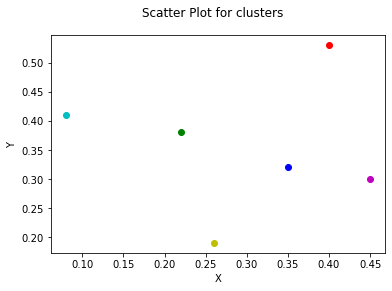

In [6]:
hierarchical_clustering(data,"single",6)

###### First data[5] and data[2] will merge, i.e. point P3 and P6 from the blog

[0, 1, 2, 3, 4, 2]


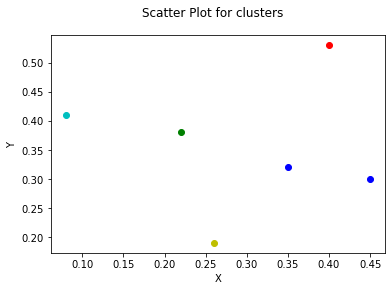

In [7]:
hierarchical_clustering(data,"single",5)
#you can see that the color of data[2] and data[5] became same, thus they are in same cluster now

###### Next merger data[1] and data[4],  i.e. P2 and P5 

[0, 1, 2, 3, 1, 2]


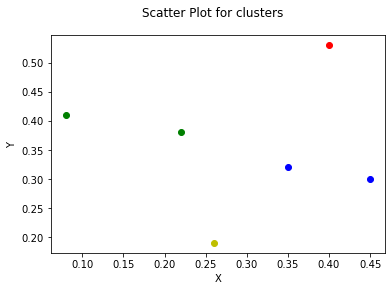

In [8]:
hierarchical_clustering(data,"single",4)
#you can see that the color of data[1] and data[4] also became same in color, thus they are in same cluster now

###### Next merger, 2 clusters formed above will merge

[0, 1, 1, 3, 1, 1]


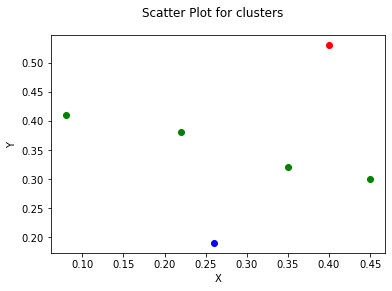

In [9]:
hierarchical_clustering(data,"single",3)

[0, 1, 1, 1, 1, 1]


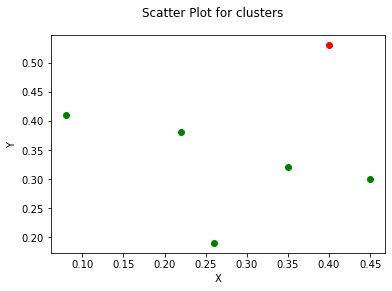

In [10]:
hierarchical_clustering(data,"single",2)

###### Finally all are in one cluster

[0, 0, 0, 0, 0, 0]


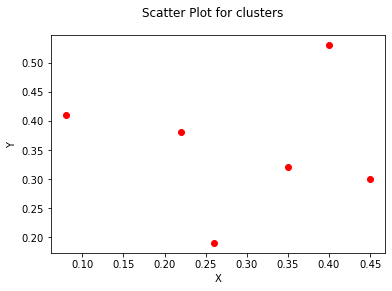

In [11]:
hierarchical_clustering(data,"single",1)